Aims:
- Label some BY4741 time series as oscillating vs non-oscillating.  50 for now, can increase when needed.
- Use this to train an SVM
- See if it can tell apart oscillating and non-oscillating time series.  Evaluate by computing a confusion matrix

# Import data

Specify file name and sampling period

In [1]:
#filename_prefix = './data/arin/Omero19979_'
filename_prefix = './data/arin/Omero20016_'
sampling_period = 5
remain = 0.8

%matplotlib 

Using matplotlib backend: Qt5Agg


Main

In [2]:
#!/usr/bin/env python3
import os

import numpy as np
import scipy as sp
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import sklearn.metrics
import igraph as ig

import pipeline.dataexport
import pipeline.dataimport
import pipeline.periodogram
import pipeline.score
import pipeline.tsman
import pipeline.vis

import featext.tsman
import featext.graph



# FLAVIN: import data and process objects

# Import fluorescence info from CSVs
Dset_flavin = pipeline.dataimport.import_timeseries(
    filename_prefix+'flavin.csv', remain = remain)
# dummy so I get code to not complain; will be re-factored later
Dset_dcategory = [None] * len(Dset_flavin)
Dset_births = pipeline.dataimport.import_births(
    filename_prefix+'births.csv')

# Arranges information into DatasetAttr objects
Dset_data = pipeline.dataimport.CellAttr_from_datasets( \
        timeseries_df = Dset_flavin,
        categories_array = Dset_dcategory,
        births_df = Dset_births,
        sampling_pd = sampling_period)
Dset = pipeline.DatasetAttr(Dset_data)

# Add labels
strainlookup = pd.read_csv(filename_prefix+'strains.csv', \
                          index_col = 'position')
for ii, cell in enumerate(Dset.cells):
    cell.source = filename_prefix
    cell.medium.base = 'Delft'
    cell.medium.nutrients = {'glucose': 10}

    cell.strain = strainlookup.loc[cell.position].strain

    cell.flavin = pipeline.Fluo('flavin')
    cell.flavin.exposure = 60
    cell.flavin.reading = cell.y
    cell.flavin.category = Dset_dcategory[ii]


# mCherry: import data and process objects
try:
    Dset_mCherry_unsliced = pipeline.dataimport.import_timeseries(
        filename_prefix+'mCherry.csv', remain = remain)
    # restrict to cells with flavin readings
    idx_both = list(set(Dset_flavin.cellID) & set(Dset_mCherry_unsliced.cellID))
    Dset_mCherry = \
            Dset_mCherry_unsliced.loc[Dset_mCherry_unsliced.cellID.isin(idx_both)]

    # Arranges information into DatasetAttr objects
    # dummy -- will be better when I re-structure things... am just re-using a 
    # function for quick-and-dirty purposes, and it's obviously redundant
    mCherry_data = pipeline.dataimport.CellAttr_from_datasets( \
            timeseries_df = Dset_mCherry,
            categories_array = Dset_dcategory,
            births_df = Dset_births,
            sampling_pd = sampling_period)
    mCherry = pipeline.DatasetAttr(mCherry_data)
    mCherry_MATLABids = [cell.MATLABid for cell in mCherry.cells]

    # Add labels
    for ii, cell in enumerate(Dset.cells):
        cell.mCherry = pipeline.Fluo('mCherry')
        if cell.strain == 'htb2_mCherry_CRISPR':
            cell.mCherry.exposure = 100
        else:
            cell.mCherry.exposure = 0

        # loads in reading, cross-referencing by MATLABid.  This is awful, I know.
        if cell.MATLABid in mCherry_MATLABids:
            cell.mCherry.reading = \
                mCherry.cells[mCherry_MATLABids.index(cell.MATLABid)].y
except FileNotFoundError as error:
    print(error)
    print(f'No mCherry time series associated with this experiment: {filename_prefix}')

[Errno 2] No such file or directory: './data/arin/Omero20016_mCherry.csv'
No mCherry time series associated with this experiment: ./data/arin/Omero20016_


# Choose a list of cells as working data

List strains

In [3]:
print(set([cell.strain for cell in Dset.cells]))

{'by4741', 'zwf1_Del'}


Define `Wlist` as working data

In [28]:
#Wlist = Dset.cells
Wlist = [cell for cell in Dset.cells if cell.strain == 'by4741']
len(Wlist)

394

# Processing time series

## Range

Chop up time series according to `interval_start` and `interval_end`, then remove cells that have NaNs.  Print number of cells.

In [29]:
interval_start = 25
interval_end = 168
#interval_start = 0
#interval_end = 223

for cell in Wlist:
    cell.time = cell.time[interval_start:interval_end]
    cell.flavin.reading_processed = cell.flavin.reading[interval_start:interval_end]

Wlist = [cell for cell in Wlist if not np.isnan(cell.flavin.reading_processed).any()]
from collections import Counter
count_strain = Counter([cell.strain for cell in Wlist])
print(count_strain)

Counter({'by4741': 294})


## Detrend

Option 1: detrend by substracting by mean time series over whole population (by strain)

In [520]:
fig, ax = plt.subplots()
plt.plot(
    np.mean([cell.flavin.reading_processed for cell in Wlist], axis = 0))
plt.title('Before detrending')
plt.show()

strains = list(set([cell.strain for cell in Wlist]))

for strain in strains:
    mean_timeseries = np.mean([
        cell.flavin.reading_processed 
            for cell in Wlist
            if cell.strain == strain],
        axis = 0)
    for cell in Wlist:
        if cell.strain == strain:
            cell.flavin.reading_processed = cell.flavin.reading_processed - mean_timeseries
            
fig, ax = plt.subplots()
plt.plot(
    np.mean([cell.flavin.reading_processed for cell in Wlist], axis = 0),)
plt.title('After detrending')
plt.show()

Option 2: Sliding window (Alán)

In [30]:
fig, ax = plt.subplots()
plt.plot(
    np.mean([cell.flavin.reading_processed for cell in Wlist], axis = 0),)
plt.title('Before detrending')
plt.show()

# https://git.ecdf.ed.ac.uk/swain-lab/python-pipeline/pipeline-core/-/blob/d209bfd0bceee7a474ad774f02f4b24701ba721c/scripts/group2.py
def moving_average(input_timeseries,
                  window = 3):
    processed_timeseries = np.cumsum(input_timeseries, dtype=float)
    processed_timeseries[window:] = processed_timeseries[window:] - processed_timeseries[:-window]
    return processed_timeseries[window - 1 :] /  window

strains = list(set([cell.strain for cell in Wlist]))
window = 45

for cell in Wlist:
    cell.flavin.reading_processed = cell.flavin.reading_processed/np.mean(cell.flavin.reading_processed)
    flavin_moving_average = moving_average(cell.flavin.reading_processed, window)
    flavin_shifted = cell.flavin.reading_processed[window//2 : -window//2]
    cell.flavin.reading_processed = flavin_shifted / flavin_moving_average[0:len(flavin_shifted)]
    
fig, ax = plt.subplots()
plt.plot(
    np.mean([cell.flavin.reading_processed for cell in Wlist], axis = 0),)
plt.title('After detrending')
plt.show()

## Smoothing/Filtering

(**WARNING: WORK IN PROGRESS**) Apply high-pass and low-pass filters

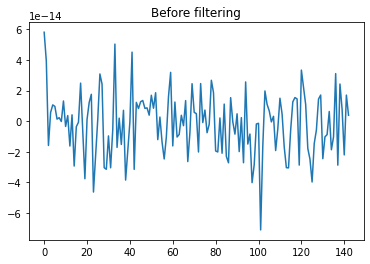

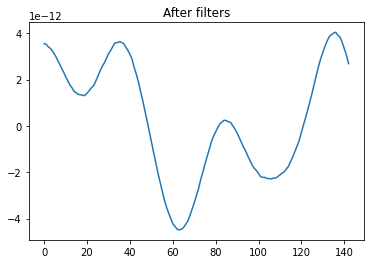

In [126]:
import scipy.signal as signal

fig, ax = plt.subplots()
plt.plot(
    np.mean([cell.flavin.reading_processed for cell in Wlist], axis = 0),)
plt.title('Before filtering')
plt.show()

def highpass_filter(data, freq, fs):
    b, a = signal.butter(5, freq, btype = 'highpass', fs = fs)
    y = signal.filtfilt(b, a, data)
    return y

def notch_filter(data, freq, fs):
    Q = 30
    b, a = signal.iirnotch(freq, Q, fs)
    y = signal.filtfilt(b, a, data)
    return y

for cell in Wlist:
    cell.flavin.reading_processed = highpass_filter(cell.flavin.reading_processed, freq=1/72, fs = 1)
    cell.flavin.reading_processed = notch_filter(cell.flavin.reading_processed, freq = 1/2, fs = 1)
    
fig, ax = plt.subplots()
plt.plot(
    np.mean([cell.flavin.reading_processed for cell in Wlist], axis = 0),)
plt.title('After filters')
plt.show()

## Normalisation

Option 1: Use standard scaler

**Risk: data leakage**

In [7]:
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots()
plt.plot(Wlist[0].flavin.reading_processed)
plt.title('Before normalisation')
plt.show()

data_array = np.array([cell.flavin.reading_processed for cell in Wlist])
scaler = StandardScaler()
scaler.fit(data_array)
data_array_transformed = scaler.transform(data_array)
for index, timeseries in enumerate(data_array_transformed):
    Wlist[index].flavin.reading_processed = data_array_transformed[index]

fig, ax = plt.subplots()
plt.plot(Wlist[0].flavin.reading_processed)
plt.title('After normalisation')
plt.show()

Option 2: Individually, by using z-score

**Note: non-standard**

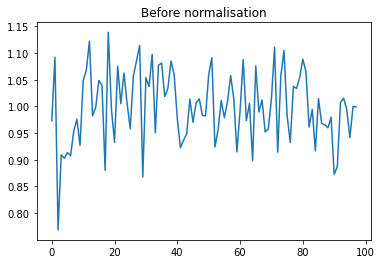

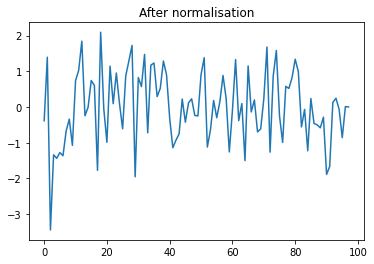

In [175]:
fig, ax = plt.subplots()
plt.plot(Wlist[0].flavin.reading_processed)
plt.title('Before normalisation')
plt.show()

for cell in Wlist:
    cell.flavin.reading_processed = (cell.flavin.reading_processed - np.mean(cell.flavin.reading_processed))/np.std(cell.flavin.reading_processed)
    
fig, ax = plt.subplots()
plt.plot(Wlist[0].flavin.reading_processed)
plt.title('After normalisation')
plt.show()

# Assign labels

Assign labels by scoring oscillations (human)

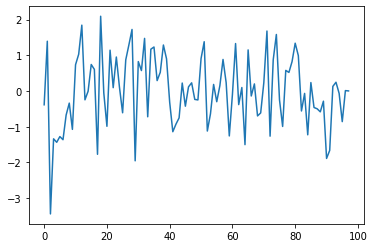

Is this oscillatory?: 0


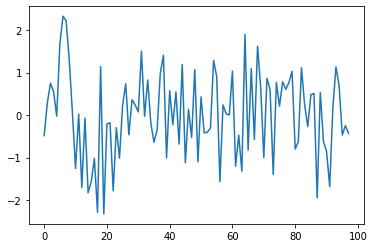

Is this oscillatory?: 0


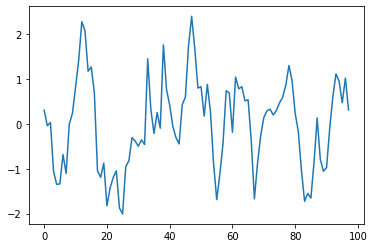

Is this oscillatory?: 2


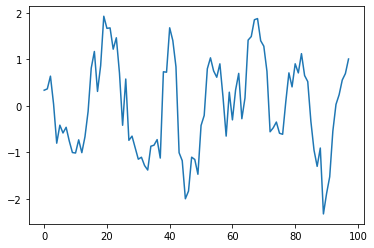

Is this oscillatory?: 1


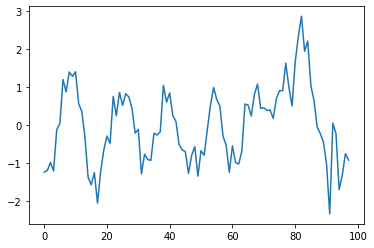

Is this oscillatory?: 1


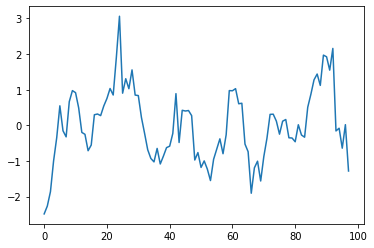

Is this oscillatory?: 1


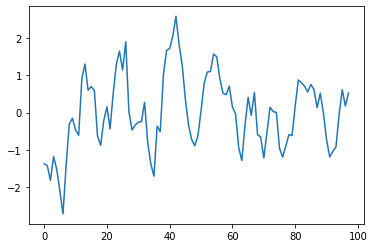

Is this oscillatory?: 2


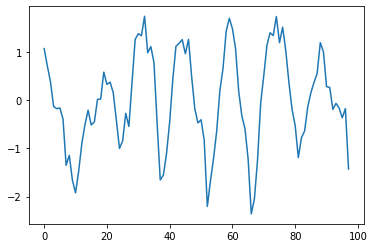

Is this oscillatory?: 1


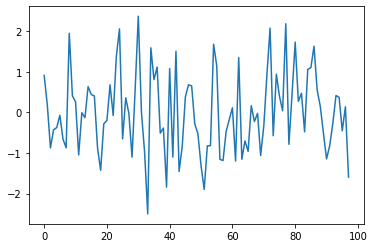

Is this oscillatory?: 0


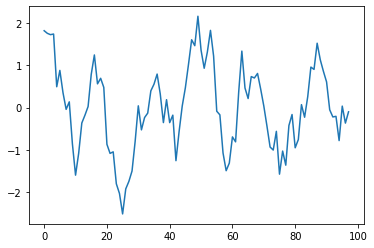

Is this oscillatory?: 1


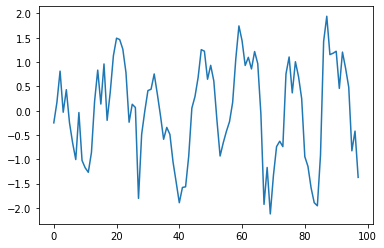

Is this oscillatory?: 1


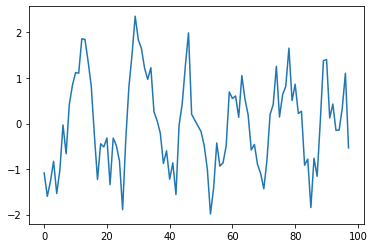

Is this oscillatory?: 1


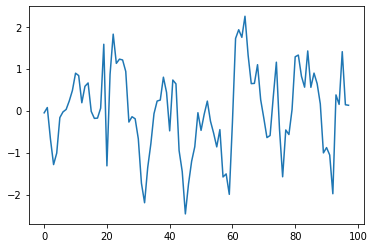

Is this oscillatory?: 1


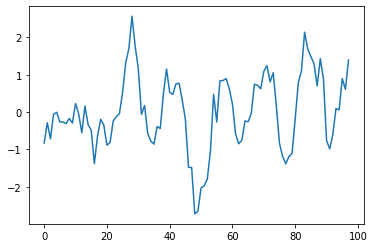

Is this oscillatory?: 1


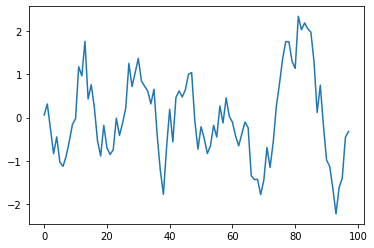

Is this oscillatory?: 1


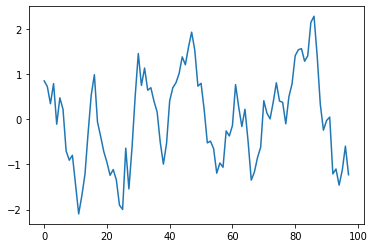

Is this oscillatory?: 1


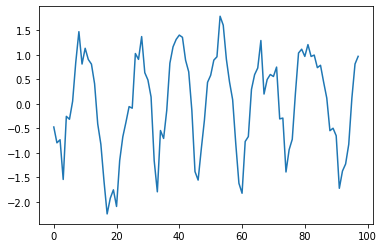

Is this oscillatory?: 1


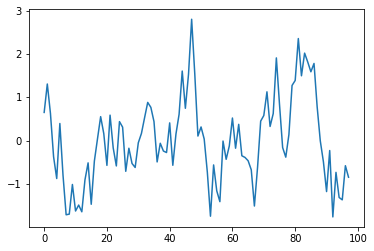

Is this oscillatory?: 2


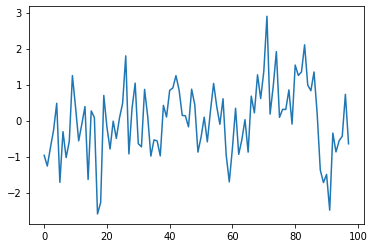

Is this oscillatory?: 0


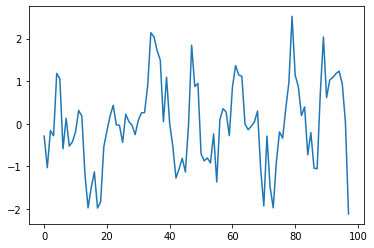

Is this oscillatory?: 2


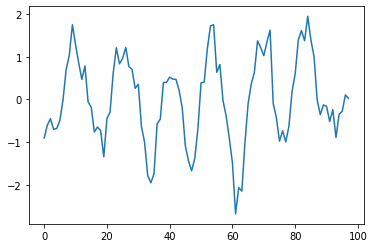

Is this oscillatory?: 1


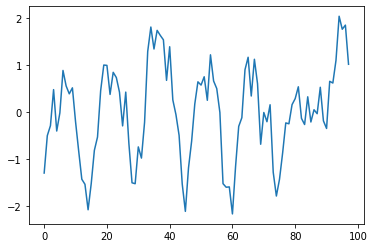

Is this oscillatory?: 1


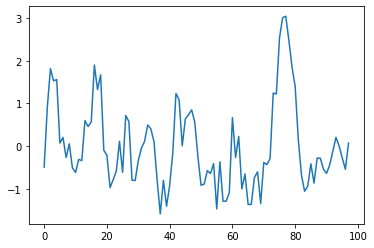

Is this oscillatory?: 2


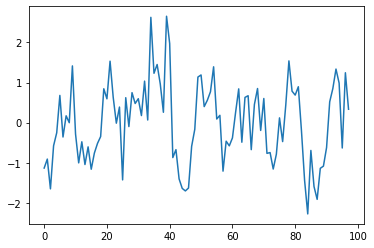

Is this oscillatory?: 2


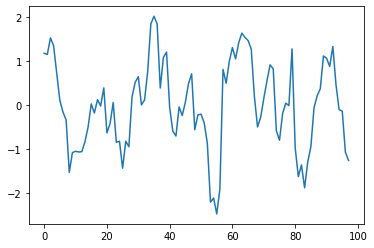

Is this oscillatory?: 2


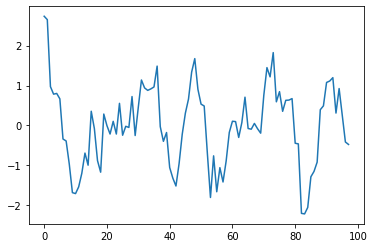

Is this oscillatory?: 2


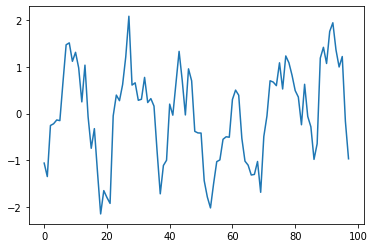

Is this oscillatory?: 1


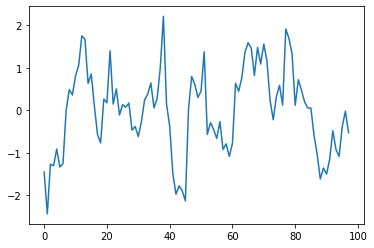

Is this oscillatory?: 2


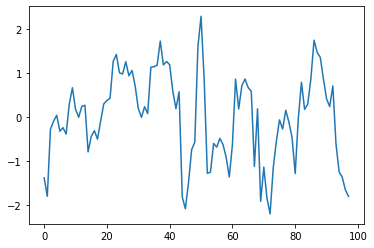

Is this oscillatory?: 2


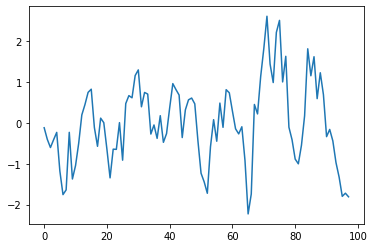

Is this oscillatory?: 2


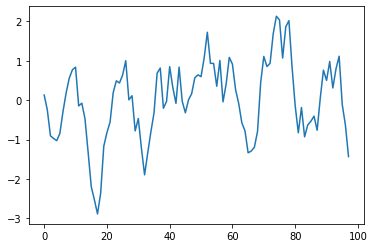

Is this oscillatory?: 1


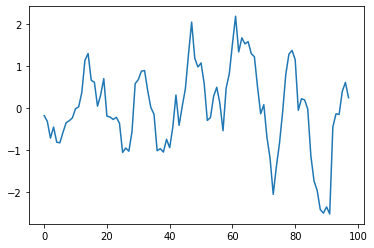

Is this oscillatory?: 1


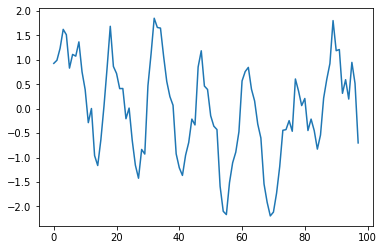

Is this oscillatory?: 1


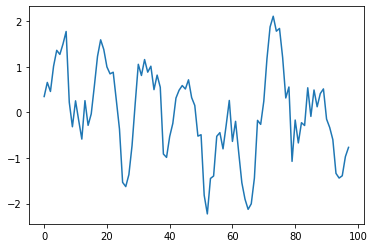

Is this oscillatory?: 1


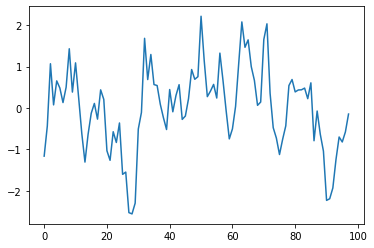

Is this oscillatory?: 2


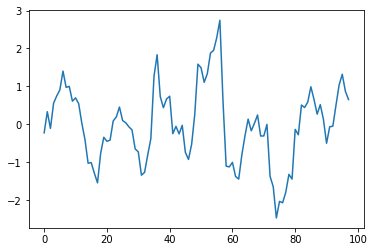

Is this oscillatory?: 1


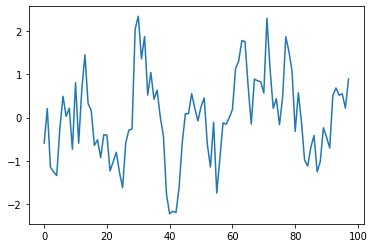

Is this oscillatory?: 2


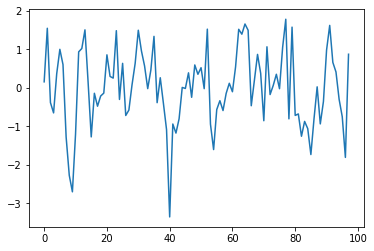

Is this oscillatory?: 0


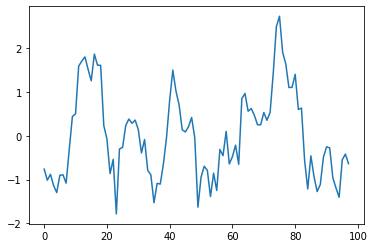

Is this oscillatory?: 2


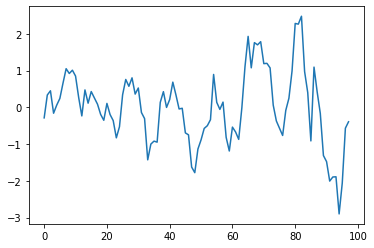

Is this oscillatory?: 1


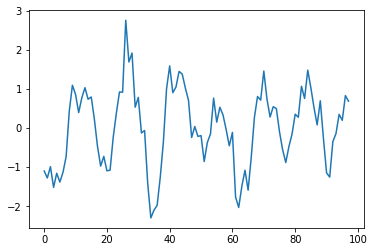

Is this oscillatory?: 1


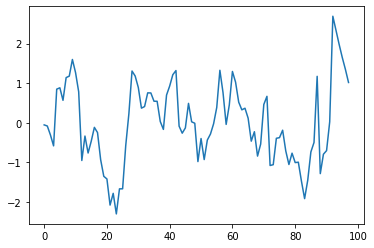

Is this oscillatory?: 2


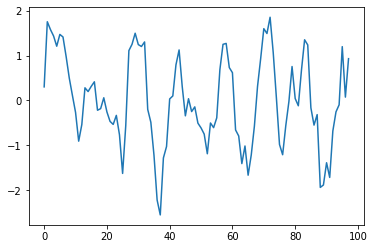

Is this oscillatory?: 1


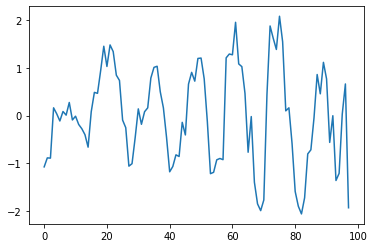

Is this oscillatory?: 1


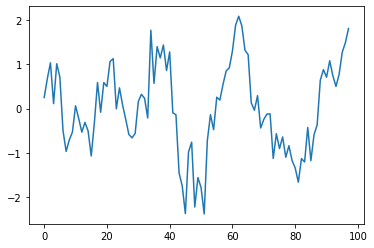

Is this oscillatory?: 2


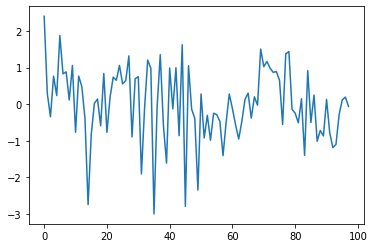

Is this oscillatory?: 0


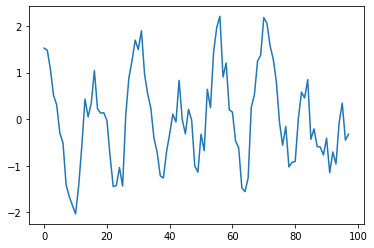

Is this oscillatory?: 1


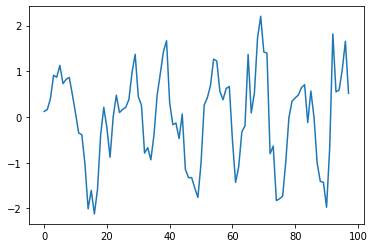

Is this oscillatory?: 1


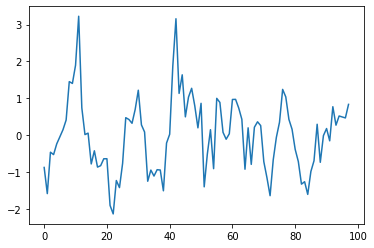

Is this oscillatory?: 2


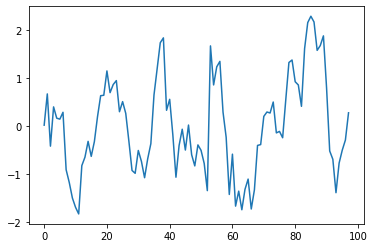

Is this oscillatory?: 2


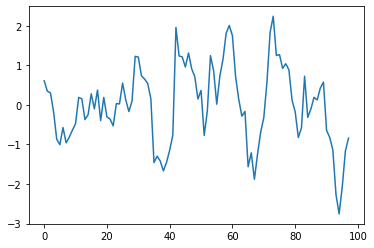

Is this oscillatory?: 2


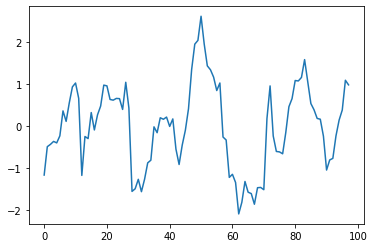

Is this oscillatory?: 2


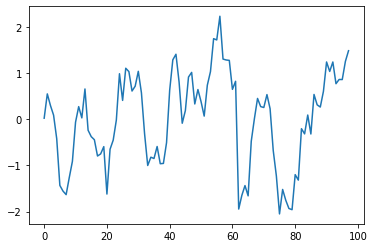

Is this oscillatory?: 2


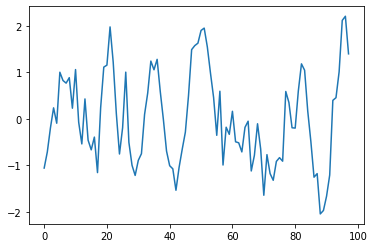

Is this oscillatory?: 2


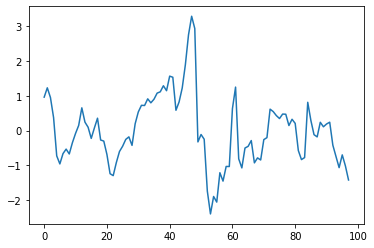

Is this oscillatory?: 0


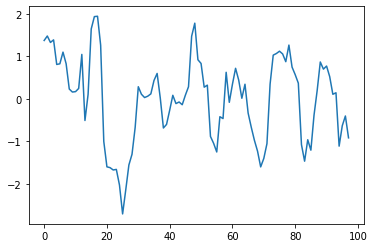

Is this oscillatory?: 2


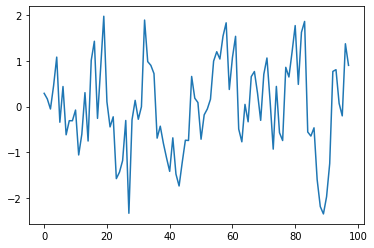

Is this oscillatory?: 0


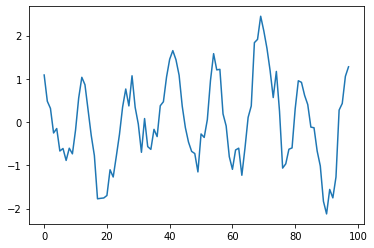

Is this oscillatory?: 1


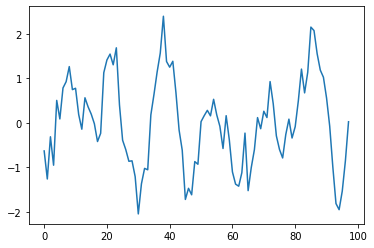

Is this oscillatory?: 1


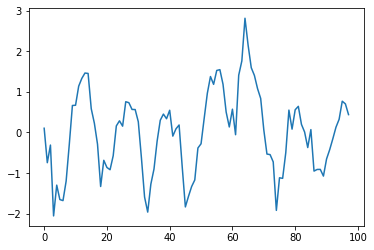

Is this oscillatory?: 1


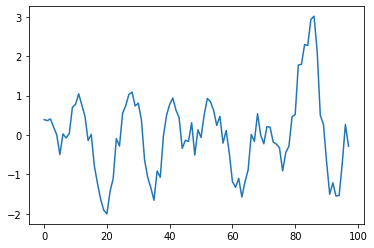

Is this oscillatory?: 1


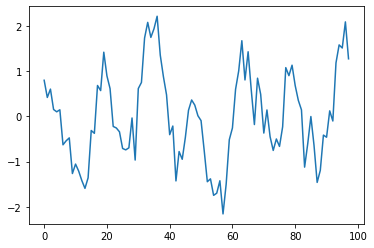

Is this oscillatory?: 1


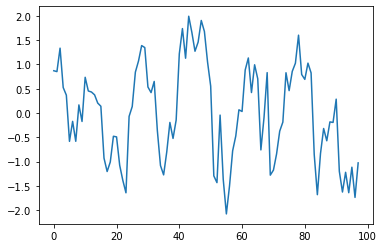

Is this oscillatory?: 1


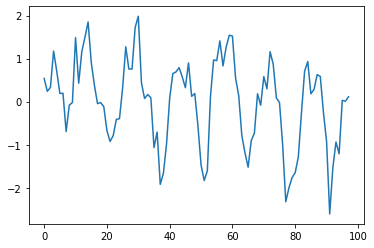

Is this oscillatory?: 1


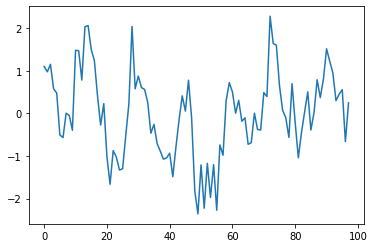

Is this oscillatory?: 1


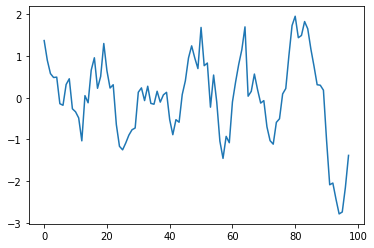

Is this oscillatory?: 1


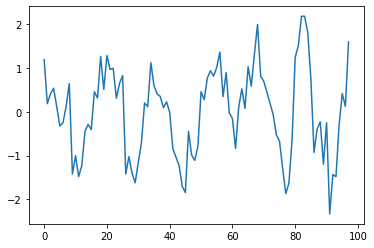

Is this oscillatory?: 1


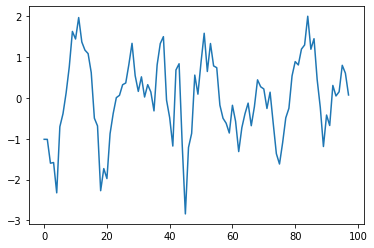

Is this oscillatory?: 2


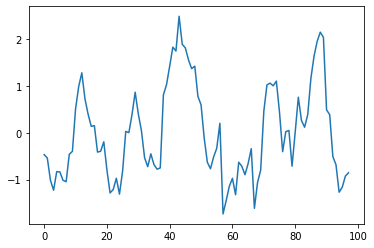

Is this oscillatory?: 2


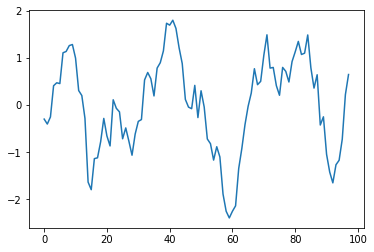

Is this oscillatory?: 2


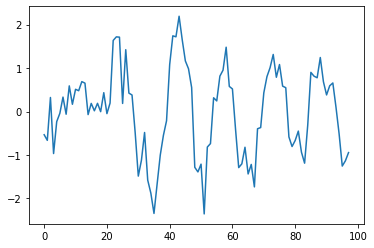

Is this oscillatory?: 1


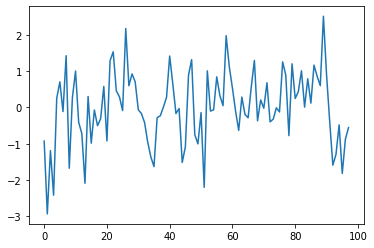

Is this oscillatory?: 0


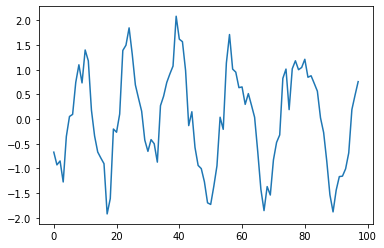

Is this oscillatory?: 1


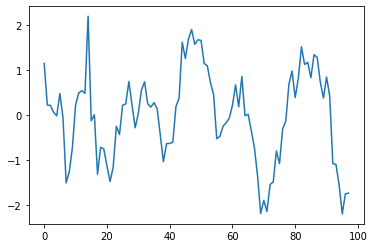

Is this oscillatory?: 2


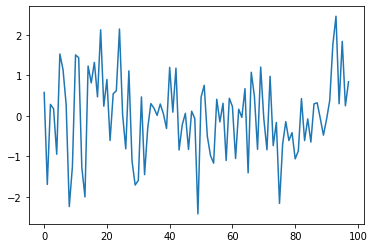

Is this oscillatory?: 0


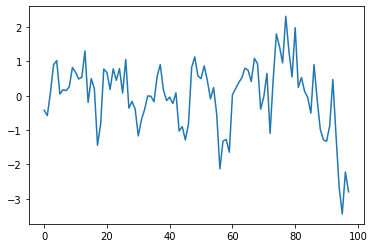

Is this oscillatory?: 2


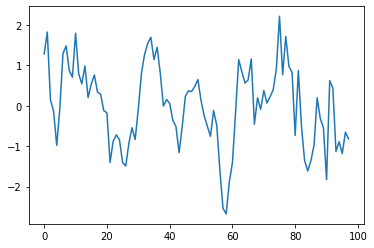

Is this oscillatory?: 2


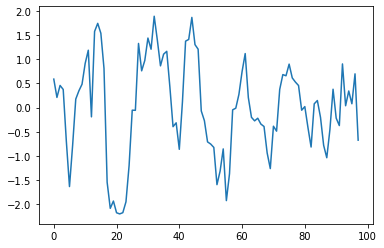

Is this oscillatory?: 2


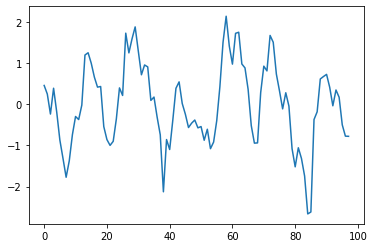

Is this oscillatory?: 1


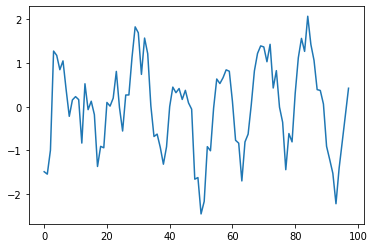

Is this oscillatory?: 1


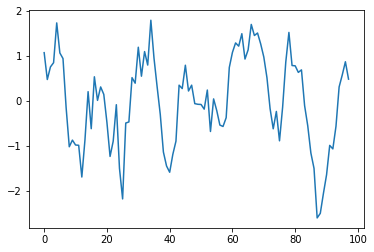

Is this oscillatory?: 2


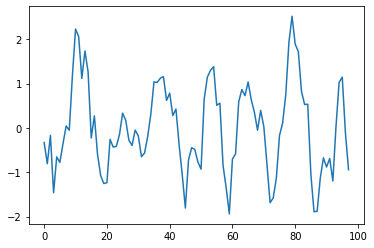

Is this oscillatory?: 1


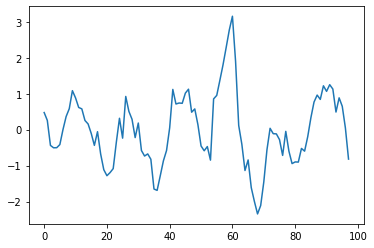

Is this oscillatory?: 1


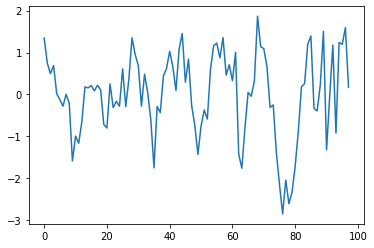

Is this oscillatory?: 2


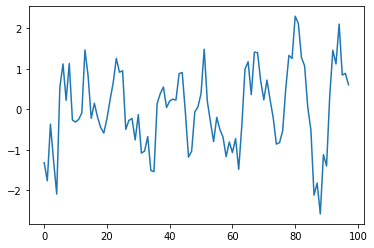

Is this oscillatory?: 2


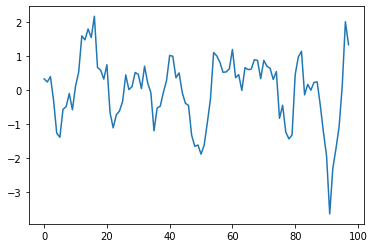

Is this oscillatory?: 2


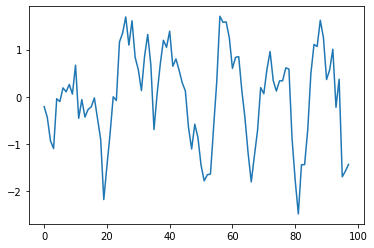

Is this oscillatory?: 1


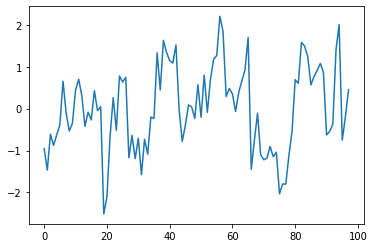

Is this oscillatory?: 2


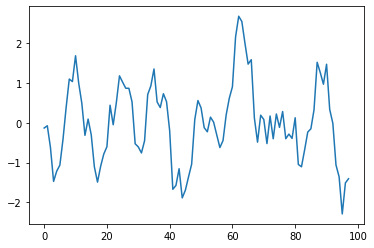

Is this oscillatory?: 2


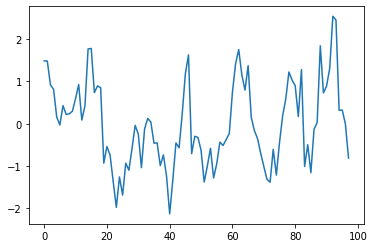

Is this oscillatory?: 2


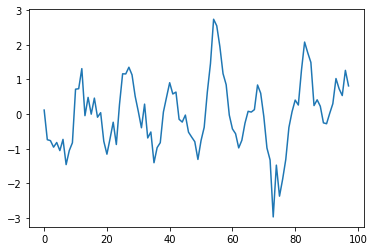

Is this oscillatory?: 1


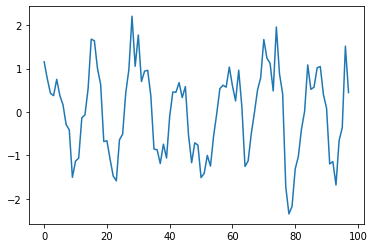

Is this oscillatory?: 1


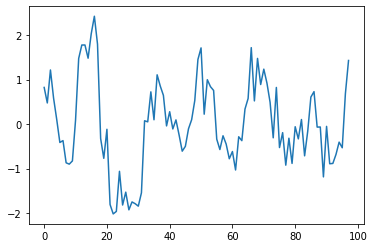

Is this oscillatory?: 2


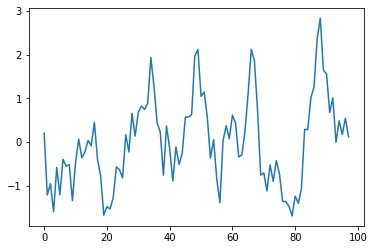

Is this oscillatory?: 1


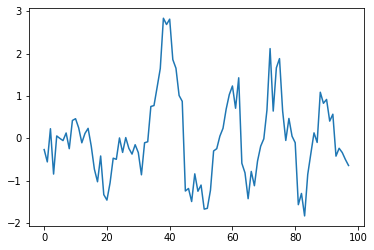

Is this oscillatory?: 1


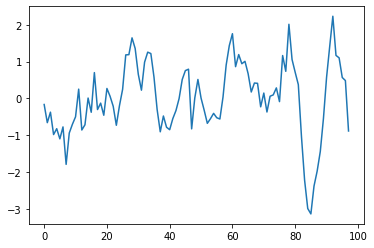

Is this oscillatory?: 2


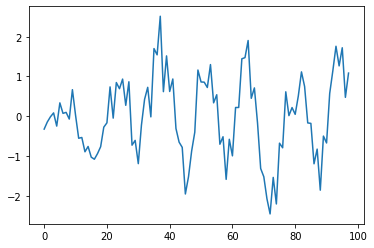

Is this oscillatory?: 1


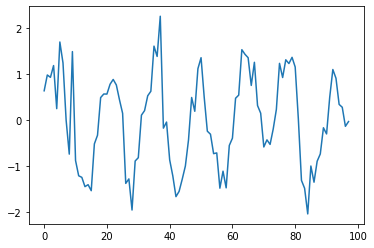

Is this oscillatory?: 1


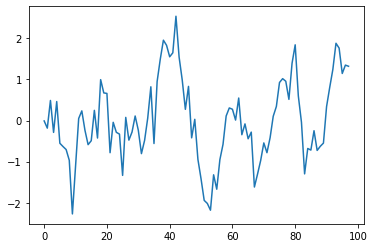

Is this oscillatory?: 2


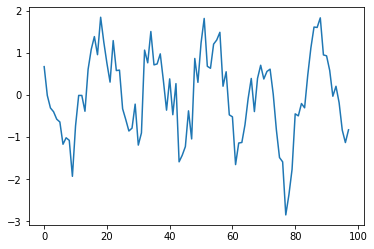

Is this oscillatory?: 1


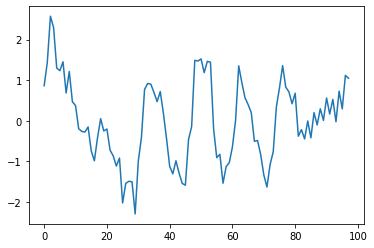

Is this oscillatory?: 2


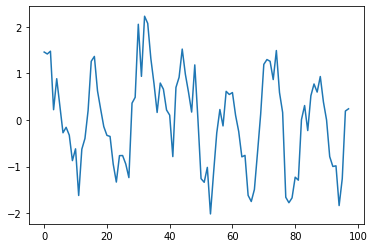

Is this oscillatory?: 1


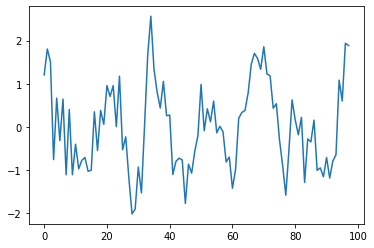

Is this oscillatory?: 1


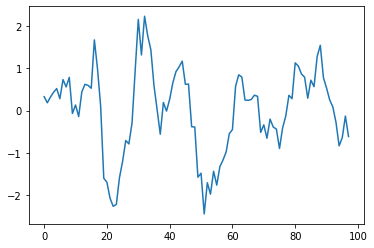

Is this oscillatory?: 2


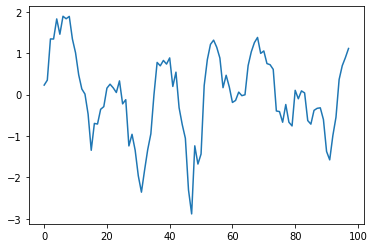

Is this oscillatory?: 1


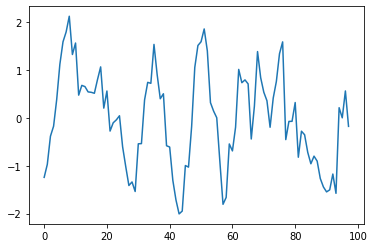

Is this oscillatory?: 2


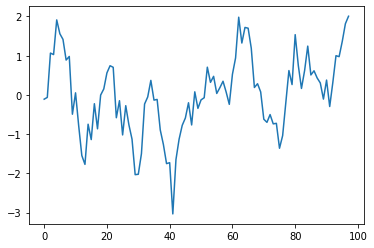

Is this oscillatory?: 2


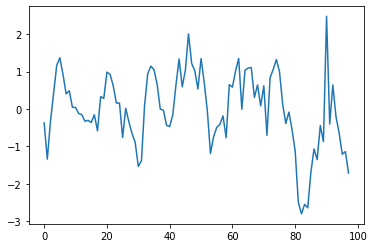

Is this oscillatory?: 2


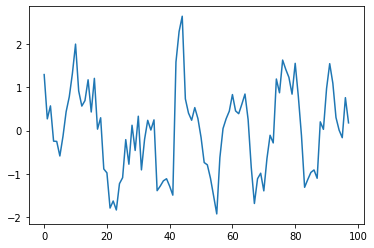

Is this oscillatory?: 2


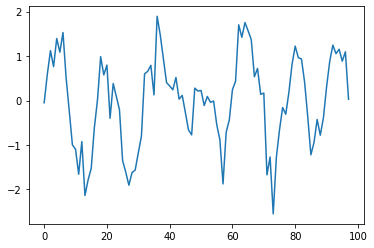

Is this oscillatory?: 1


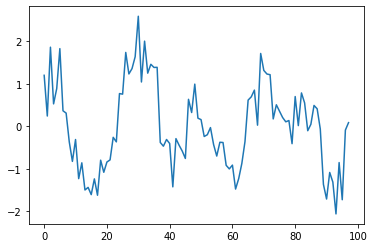

Is this oscillatory?: 2


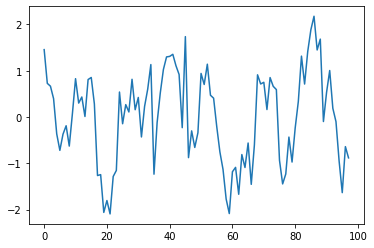

Is this oscillatory?: 2


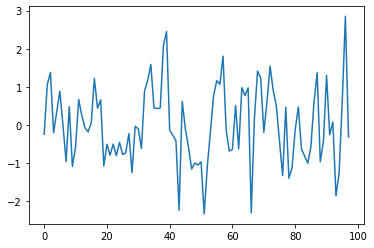

Is this oscillatory?: 0


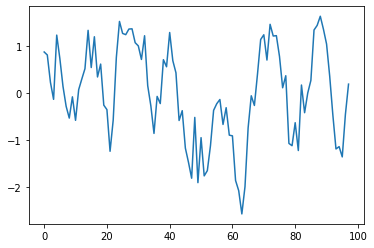

Is this oscillatory?: 1


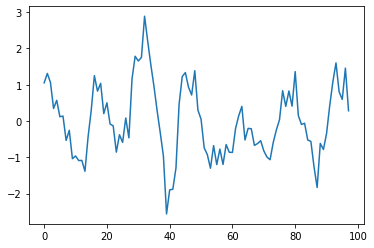

Is this oscillatory?: 1


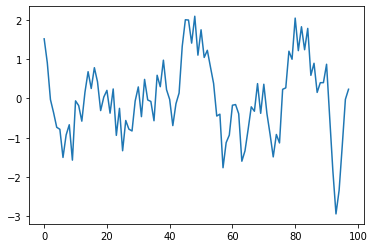

Is this oscillatory?: 2


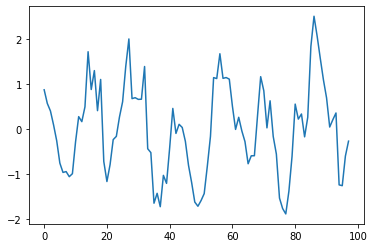

Is this oscillatory?: 1


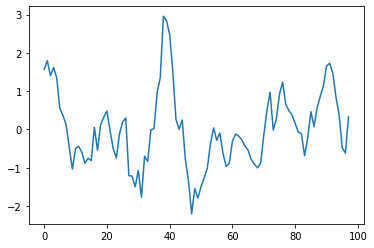

Is this oscillatory?: 2


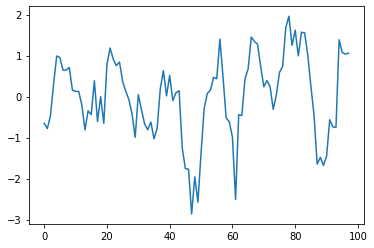

Is this oscillatory?: 1


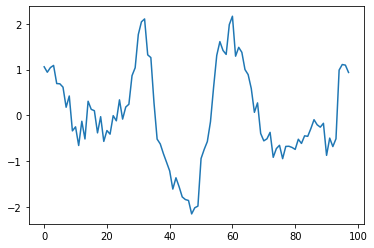

Is this oscillatory?: 0


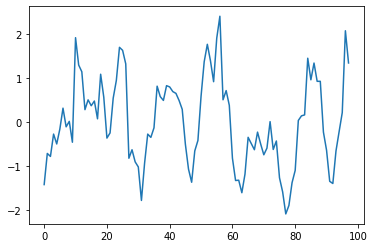

Is this oscillatory?: 2


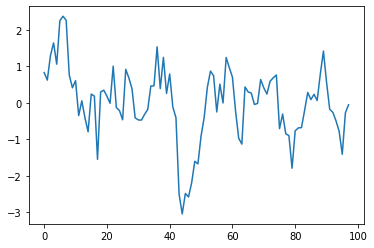

Is this oscillatory?: 2


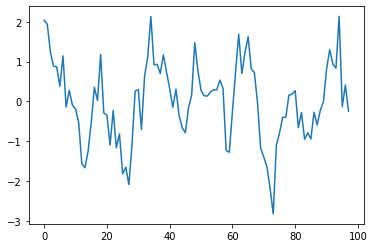

Is this oscillatory?: 2


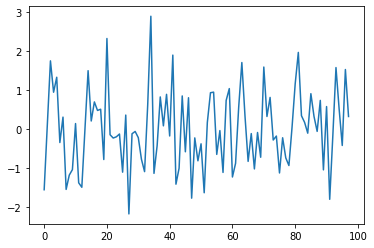

Is this oscillatory?: 0


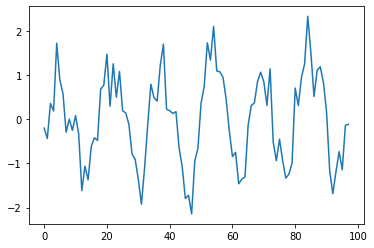

Is this oscillatory?: 1


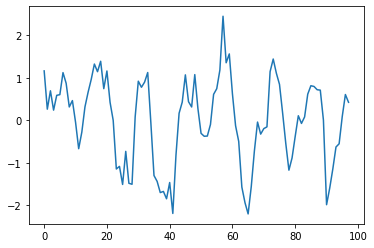

Is this oscillatory?: 1


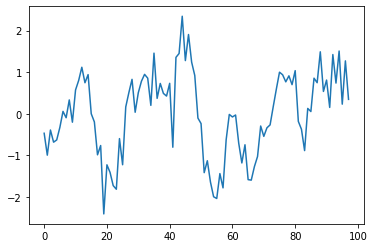

Is this oscillatory?: 2


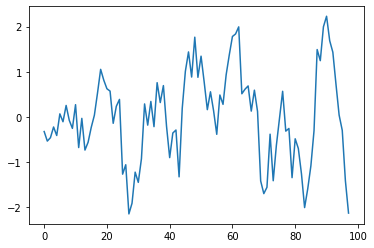

Is this oscillatory?: 2


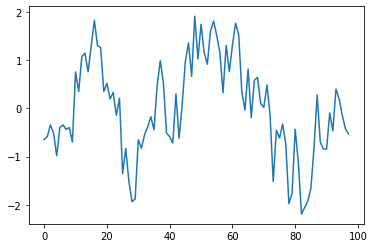

Is this oscillatory?: 2


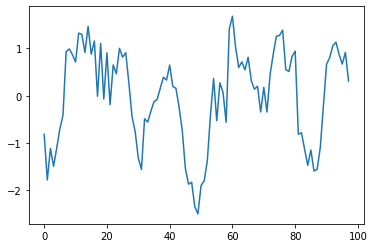

Is this oscillatory?: 2


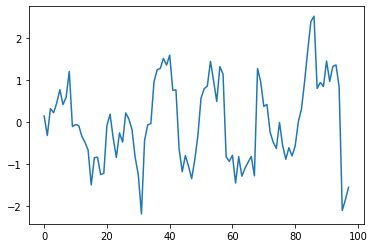

Is this oscillatory?: 1


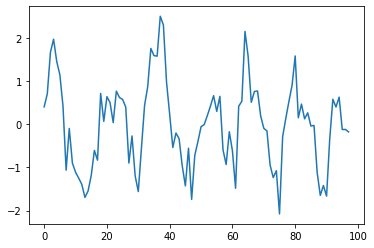

Is this oscillatory?: 1


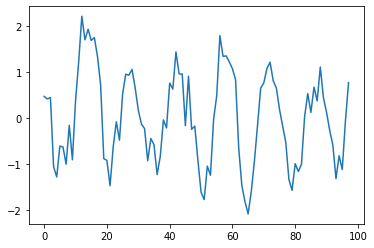

Is this oscillatory?: 1


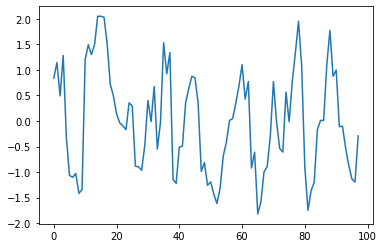

Is this oscillatory?: 1


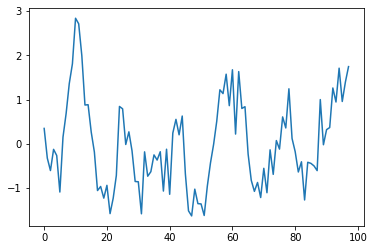

Is this oscillatory?: 2


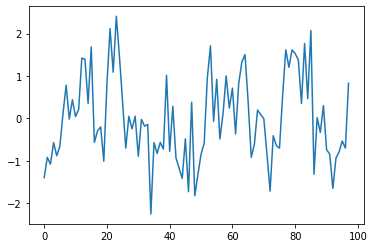

Is this oscillatory?: 0


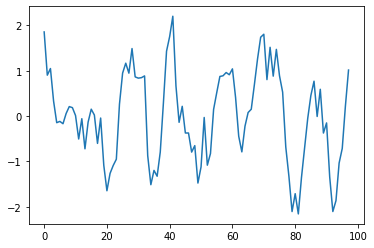

Is this oscillatory?: 1


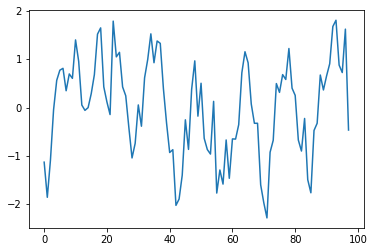

Is this oscillatory?: 2


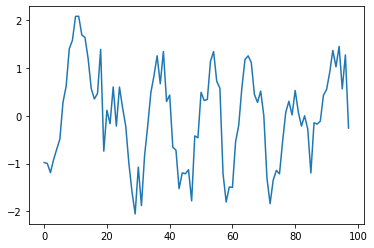

Is this oscillatory?: 1


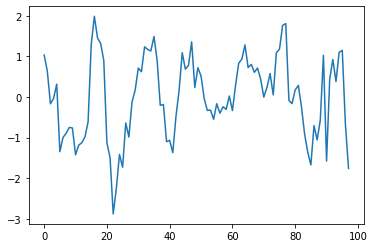

Is this oscillatory?: 2


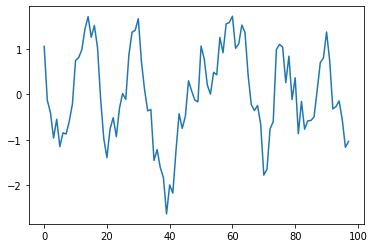

Is this oscillatory?: 1


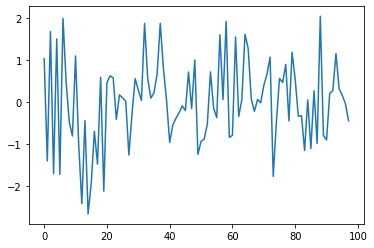

Is this oscillatory?: 0


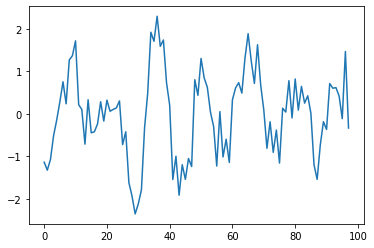

Is this oscillatory?: 2


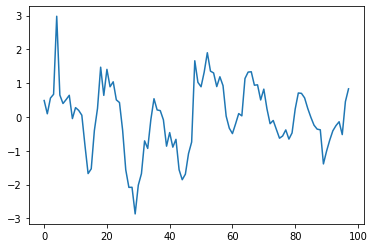

Is this oscillatory?: 1


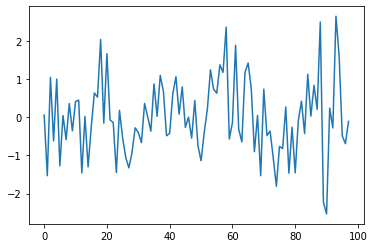

Is this oscillatory?: 0


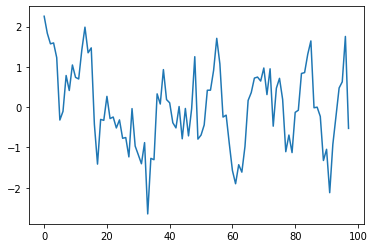

Is this oscillatory?: 2


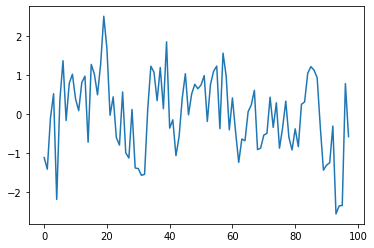

Is this oscillatory?: 0


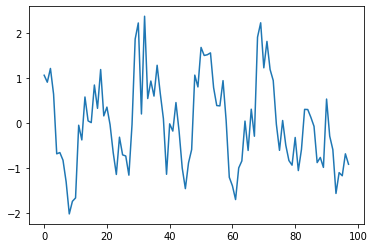

Is this oscillatory?: 2


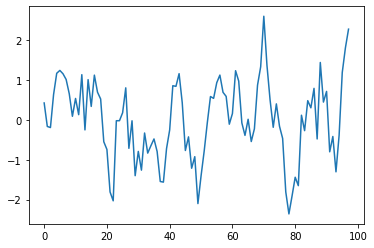

Is this oscillatory?: 2


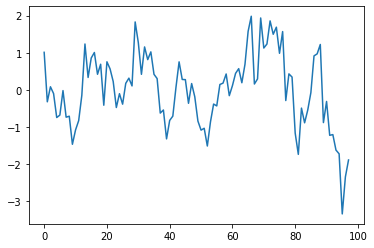

Is this oscillatory?: 2


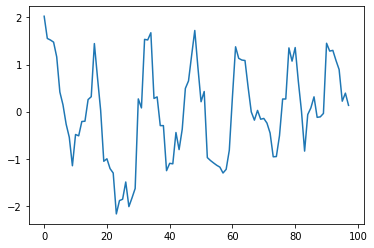

Is this oscillatory?: 1


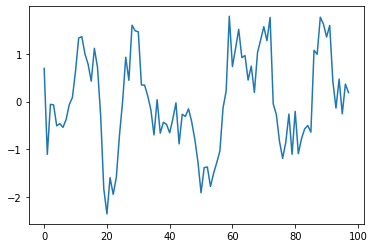

Is this oscillatory?: 2


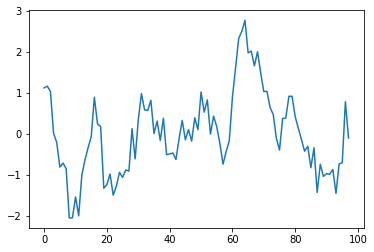

Is this oscillatory?: 2


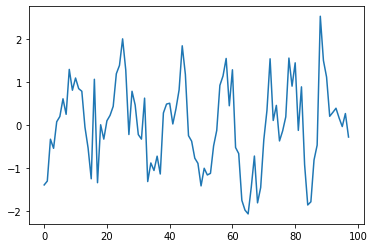

Is this oscillatory?: 2


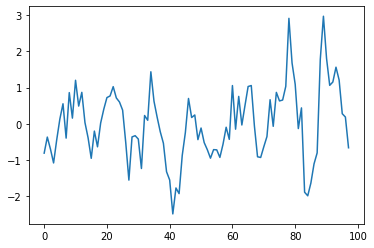

Is this oscillatory?: 1


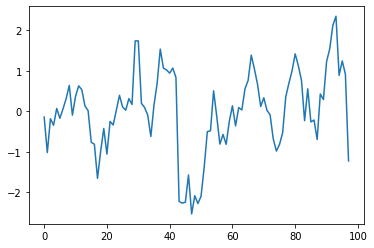

Is this oscillatory?: 2


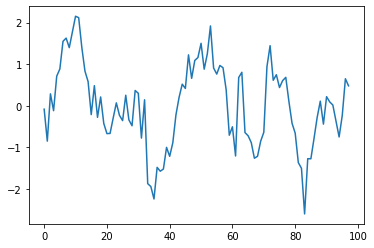

Is this oscillatory?: 2


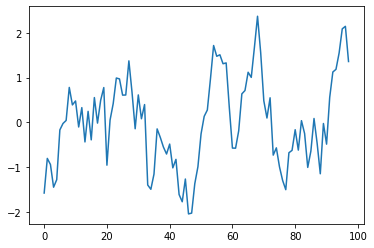

Is this oscillatory?: 2


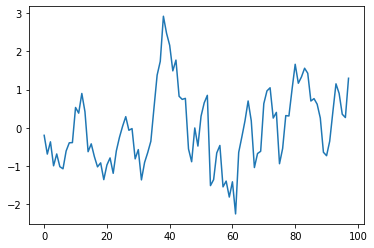

Is this oscillatory?: 2


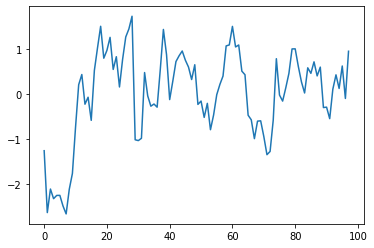

Is this oscillatory?: 2


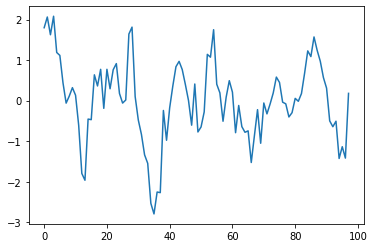

Is this oscillatory?: 2


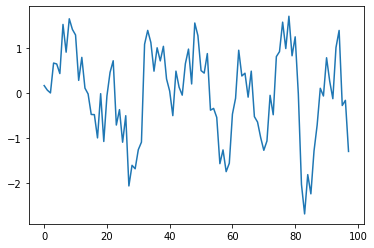

Is this oscillatory?: 2


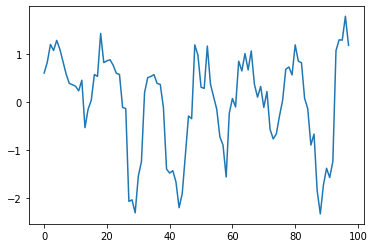

Is this oscillatory?: 1


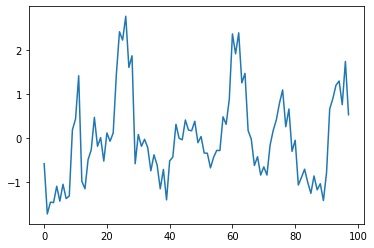

Is this oscillatory?: 2


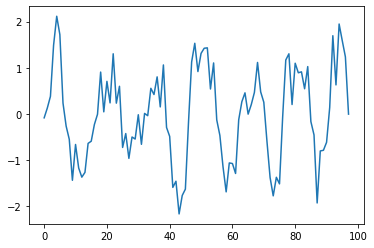

Is this oscillatory?: 1


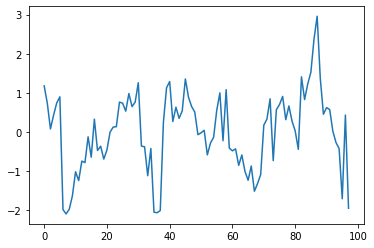

Is this oscillatory?: 0


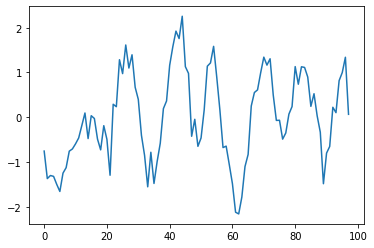

Is this oscillatory?: 1


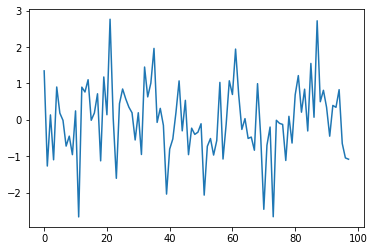

Is this oscillatory?: 0


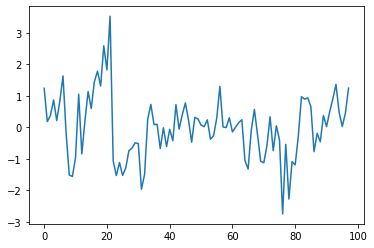

Is this oscillatory?: 0


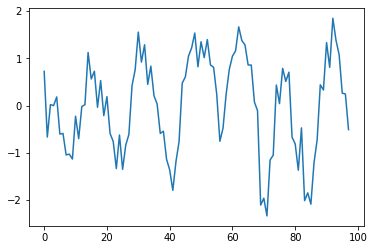

Is this oscillatory?: 1


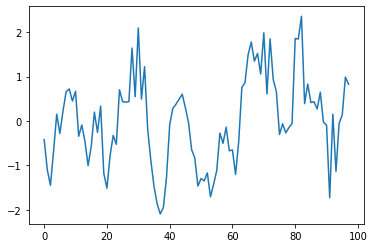

Is this oscillatory?: 2


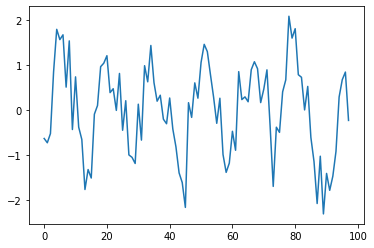

Is this oscillatory?: 1


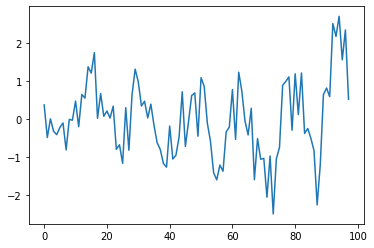

Is this oscillatory?: 1


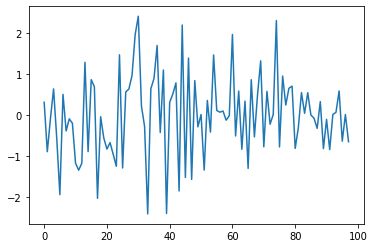

Is this oscillatory?: 0


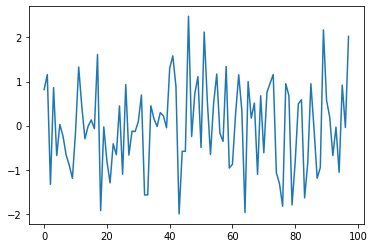

Is this oscillatory?: 0


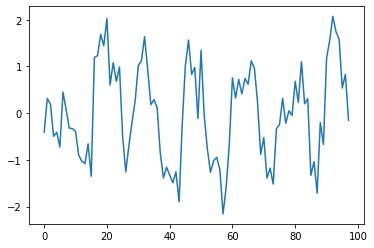

Is this oscillatory?: 1


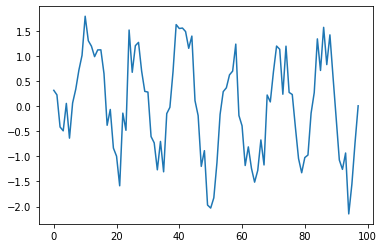

Is this oscillatory?: 1


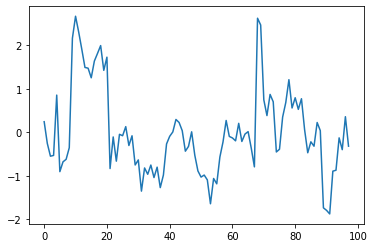

Is this oscillatory?: 0


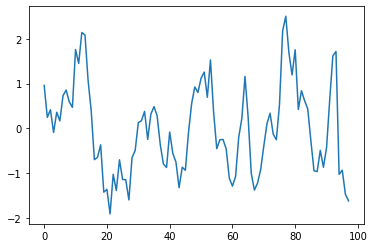

Is this oscillatory?: 2


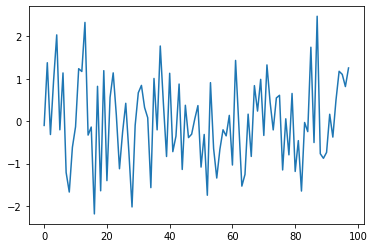

Is this oscillatory?: 0


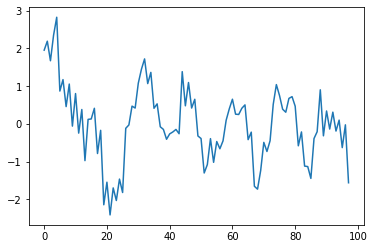

Is this oscillatory?: 1


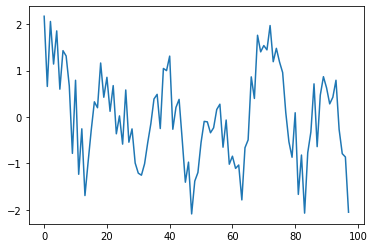

Is this oscillatory?: 1


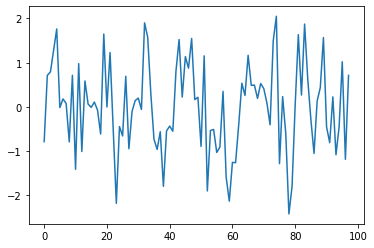

Is this oscillatory?: 0


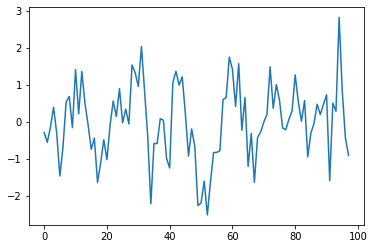

Is this oscillatory?: 2


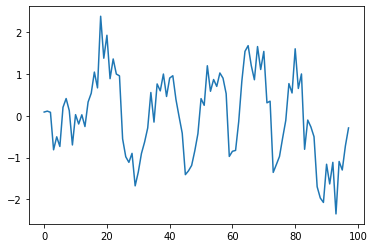

Is this oscillatory?: 1


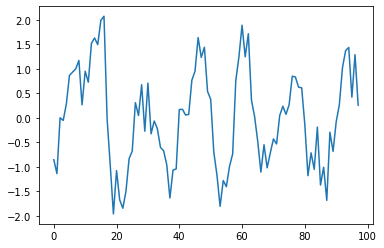

Is this oscillatory?: 1


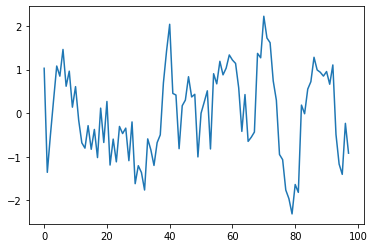

Is this oscillatory?: 0


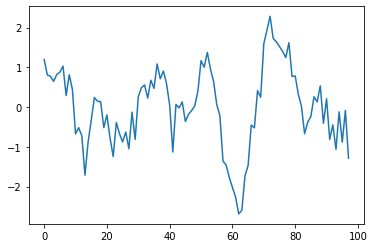

Is this oscillatory?: 2


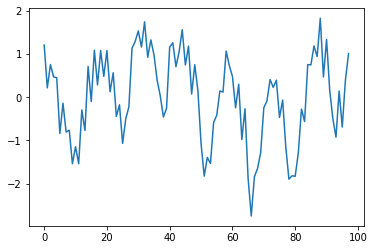

Is this oscillatory?: 1


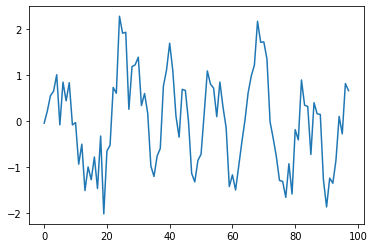

Is this oscillatory?: 1


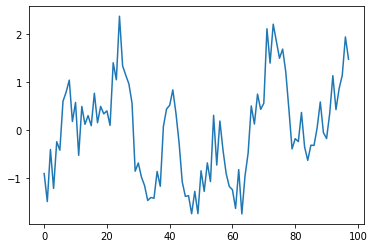

Is this oscillatory?: 2


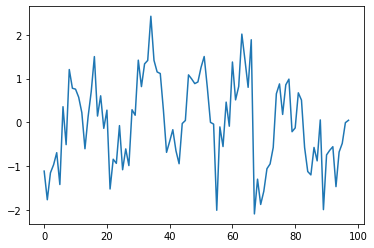

Is this oscillatory?: 1


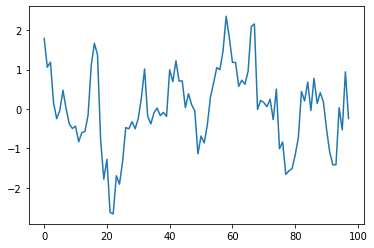

Is this oscillatory?: 2


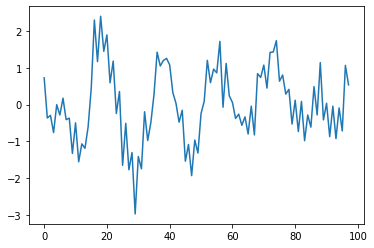

Is this oscillatory?: 1


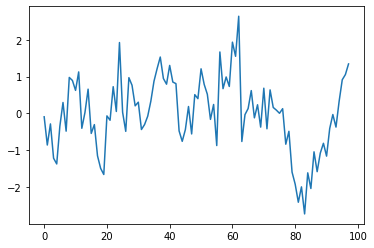

Is this oscillatory?: 2


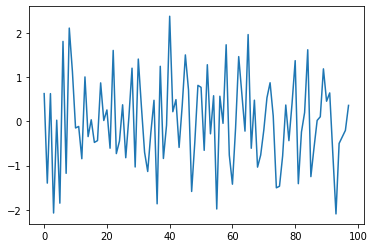

Is this oscillatory?: 0


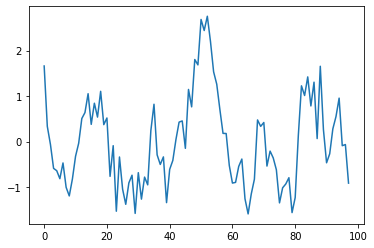

Is this oscillatory?: 2


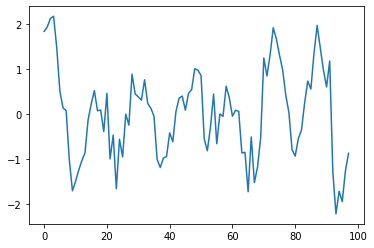

Is this oscillatory?: 2


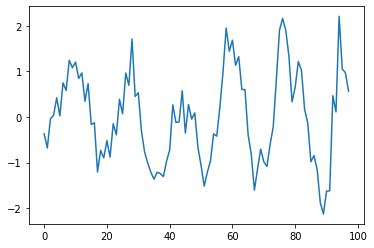

Is this oscillatory?: 1


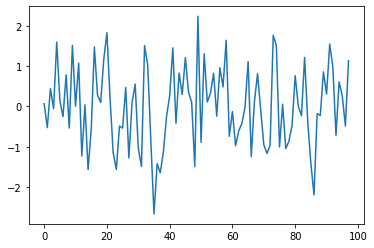

Is this oscillatory?: 0


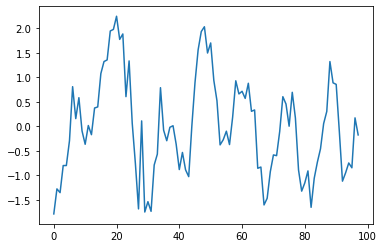

Is this oscillatory?: 1


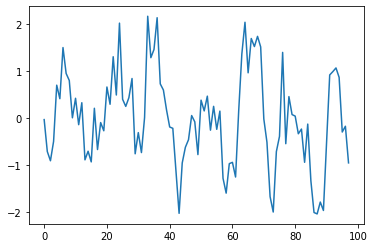

Is this oscillatory?: 14


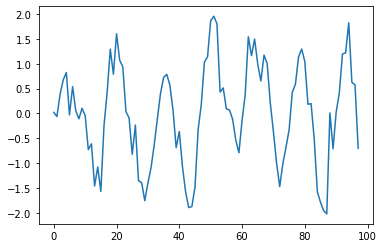

Is this oscillatory?: 1


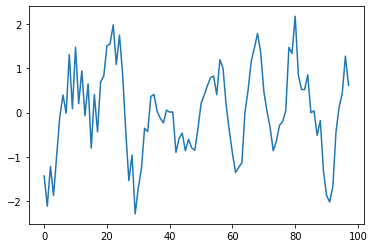

Is this oscillatory?: 1


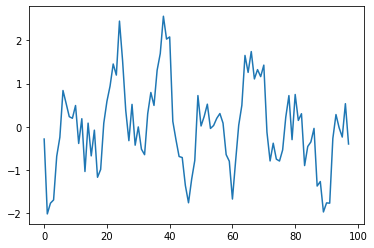

Is this oscillatory?: 1


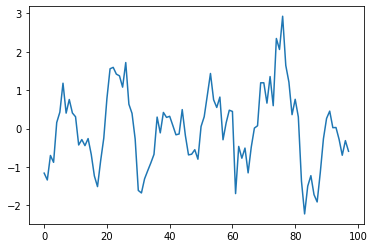

Is this oscillatory?: 1


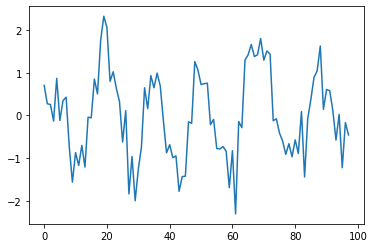

Is this oscillatory?: 1


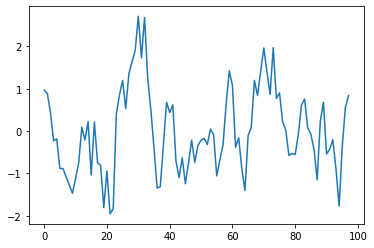

Is this oscillatory?: 2


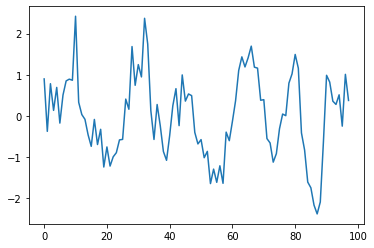

Is this oscillatory?: 1


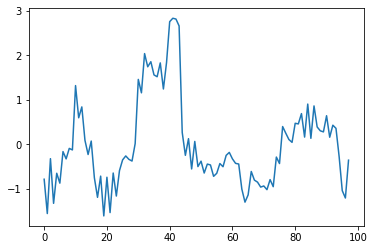

Is this oscillatory?: 0


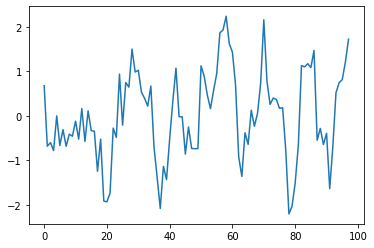

Is this oscillatory?: 2


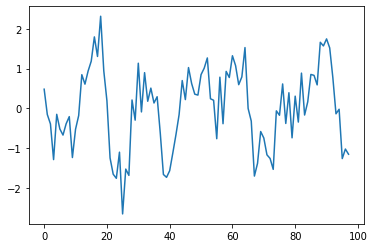

Is this oscillatory?: 2


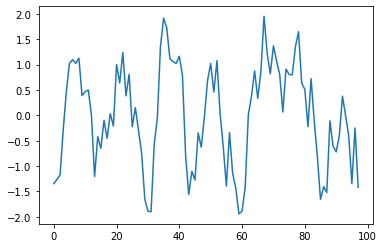

Is this oscillatory?: 1


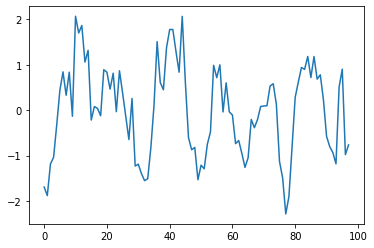

Is this oscillatory?: 1


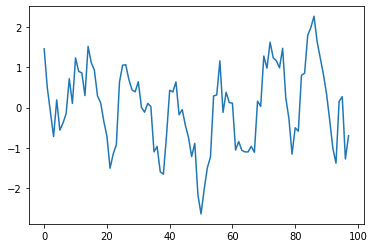

Is this oscillatory?: 1


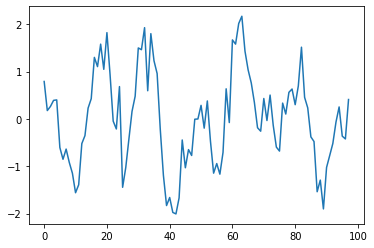

Is this oscillatory?: 2


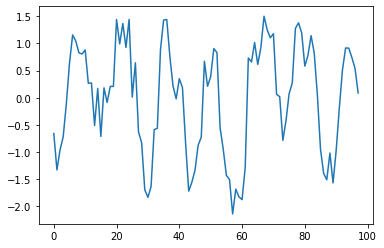

Is this oscillatory?: 1


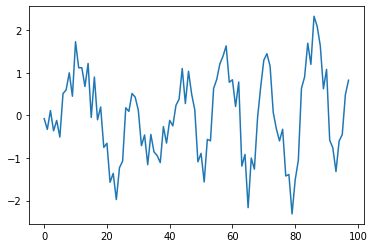

Is this oscillatory?: 1


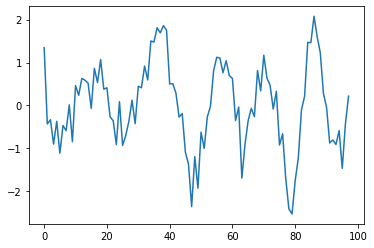

Is this oscillatory?: 1


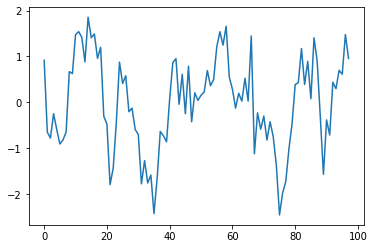

Is this oscillatory?: 2


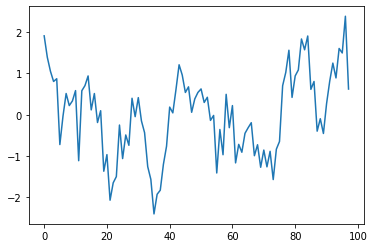

Is this oscillatory?: 0


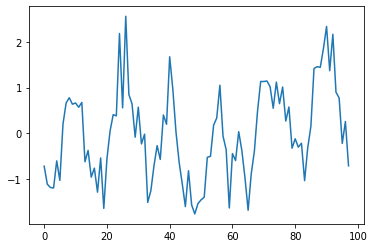

Is this oscillatory?: 2


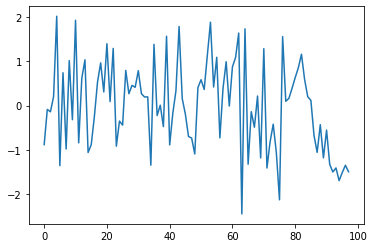

Is this oscillatory?: 0


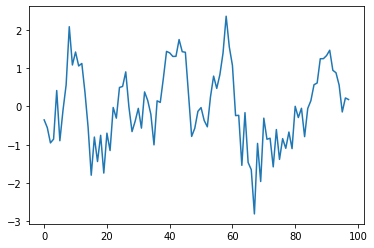

Is this oscillatory?: 2


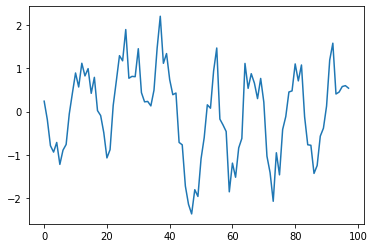

Is this oscillatory?: 1


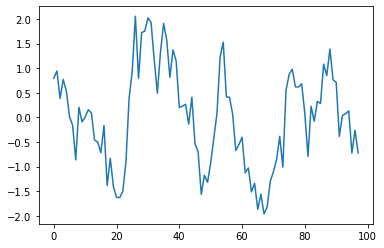

Is this oscillatory?: 2


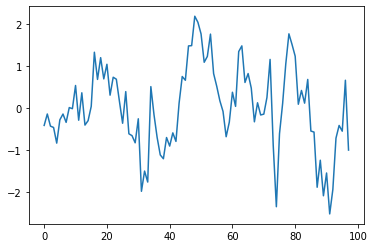

Is this oscillatory?: 2


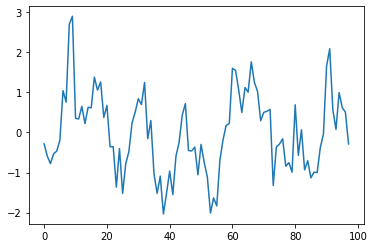

Is this oscillatory?: 2


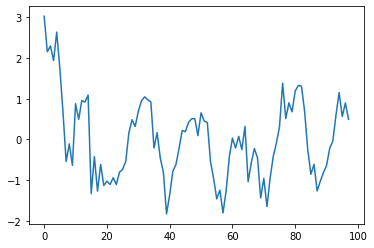

Is this oscillatory?: 1


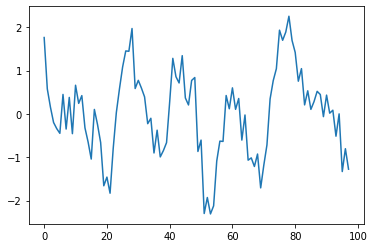

Is this oscillatory?: 2


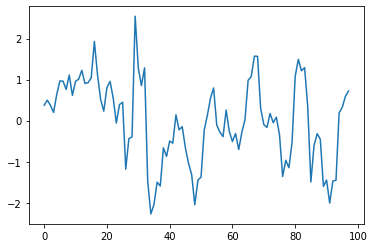

Is this oscillatory?: 0


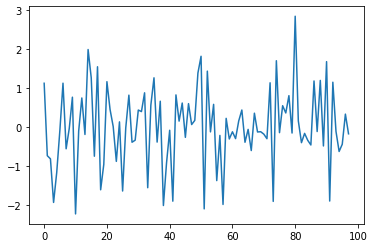

Is this oscillatory?: 0


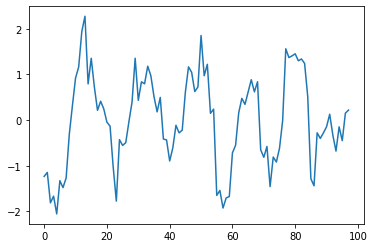

Is this oscillatory?: 1


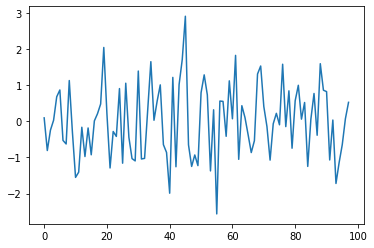

Is this oscillatory?: 0


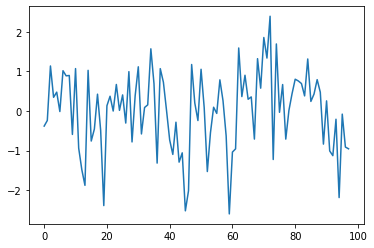

Is this oscillatory?: 0


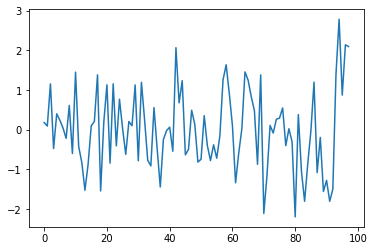

Is this oscillatory?: 0


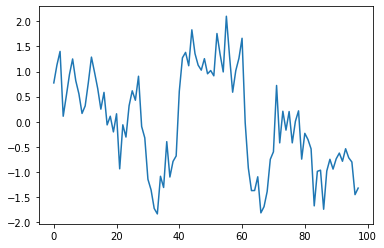

Is this oscillatory?: 2


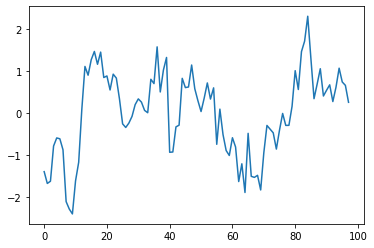

Is this oscillatory?: 2


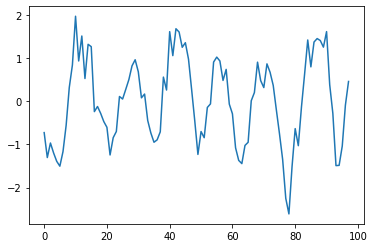

Is this oscillatory?: 1


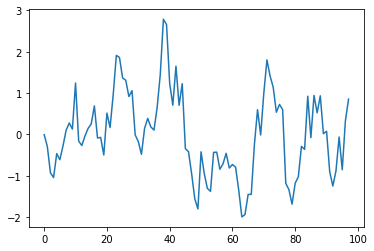

Is this oscillatory?: 1


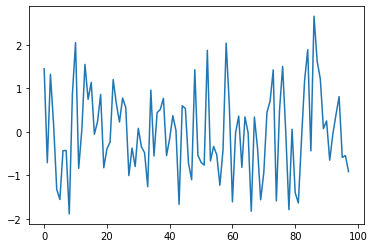

Is this oscillatory?: 0


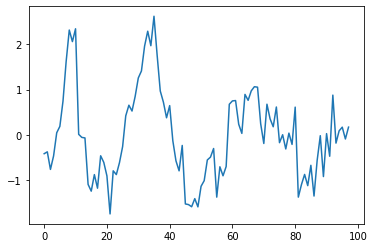

Is this oscillatory?: 0


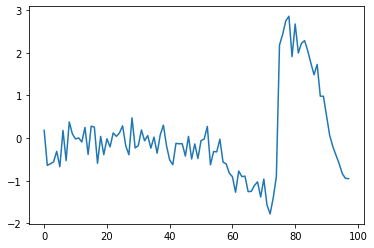

Is this oscillatory?: 0


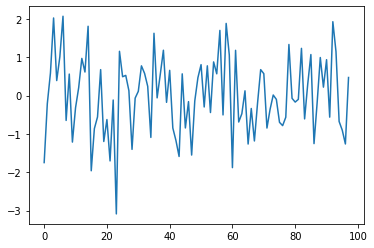

Is this oscillatory?: 0


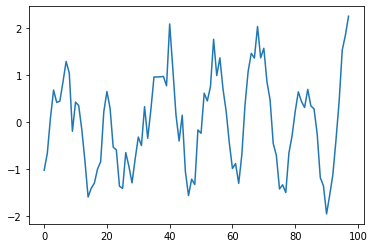

Is this oscillatory?: 1


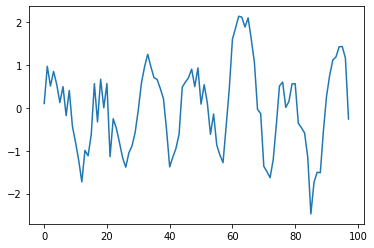

Is this oscillatory?: 1


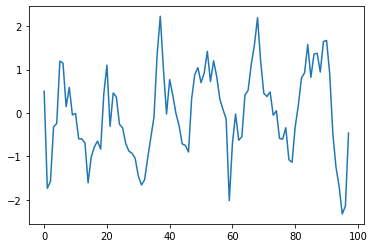

Is this oscillatory?: 1


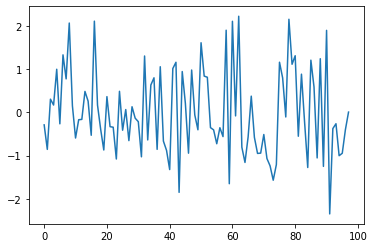

Is this oscillatory?: 0


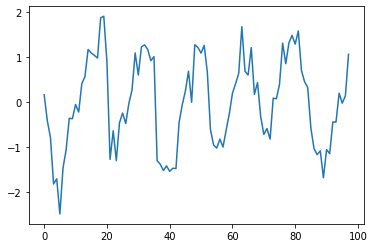

Is this oscillatory?: 1


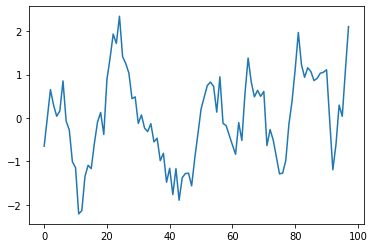

Is this oscillatory?: 2


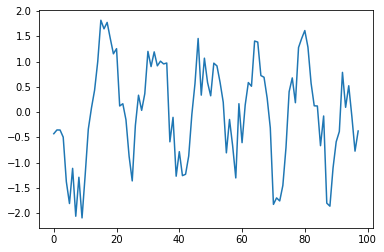

Is this oscillatory?: 1


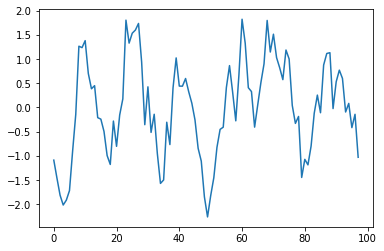

Is this oscillatory?: 1


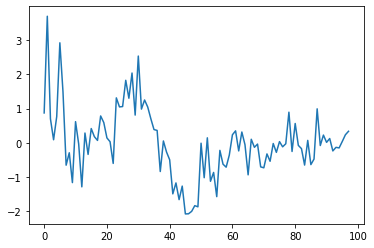

Is this oscillatory?: 0


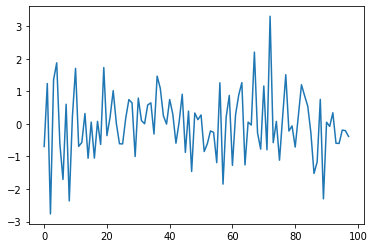

Is this oscillatory?: 0


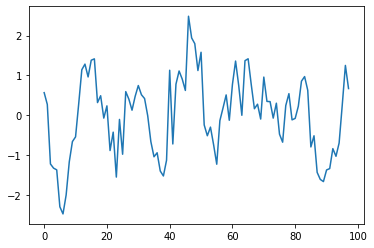

Is this oscillatory?: 2


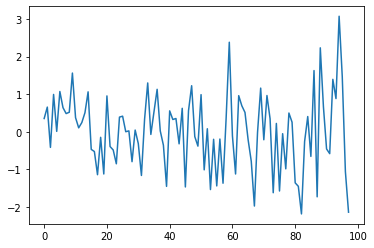

Is this oscillatory?: 0


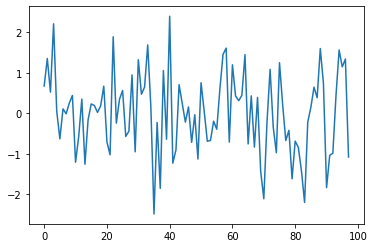

Is this oscillatory?: 0


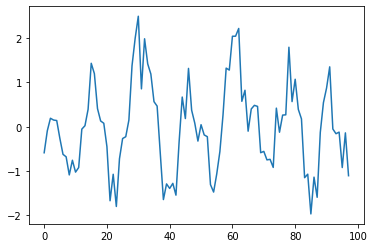

Is this oscillatory?: 1


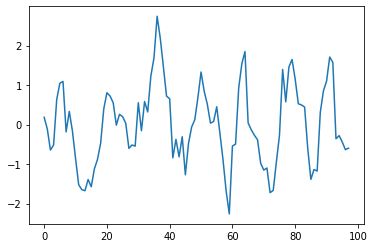

Is this oscillatory?: 1


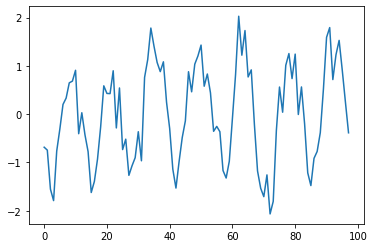

Is this oscillatory?: 1


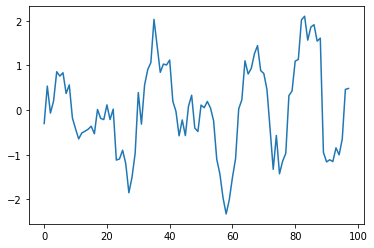

Is this oscillatory?: 2


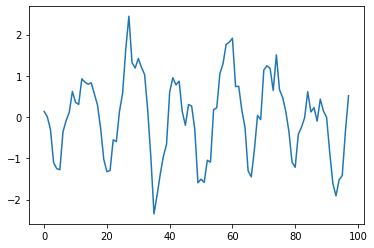

Is this oscillatory?: 1


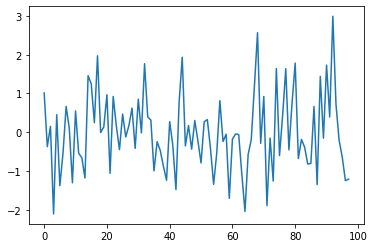

Is this oscillatory?: 0


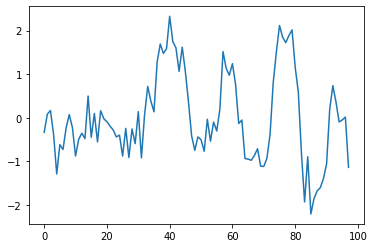

Is this oscillatory?: 2


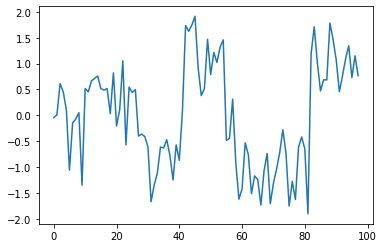

Is this oscillatory?: 0


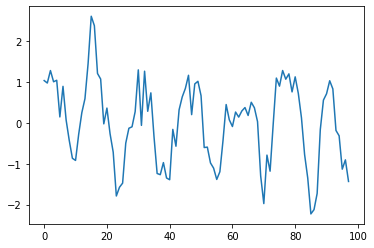

Is this oscillatory?: 1


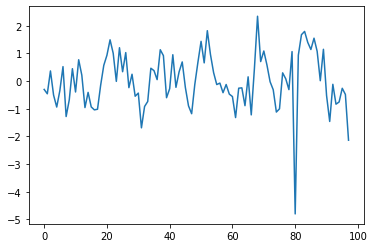

Is this oscillatory?: 1


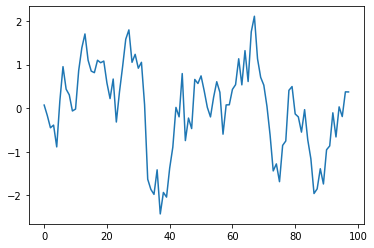

Is this oscillatory?: 2


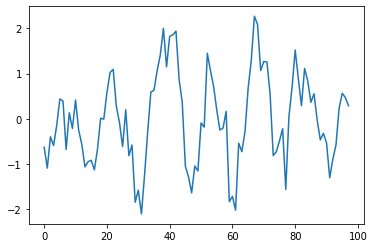

Is this oscillatory?: 1


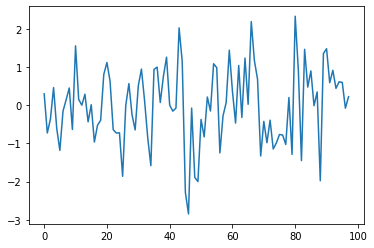

Is this oscillatory?: 0


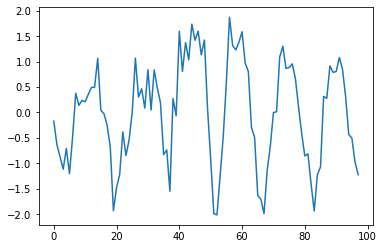

Is this oscillatory?: 1


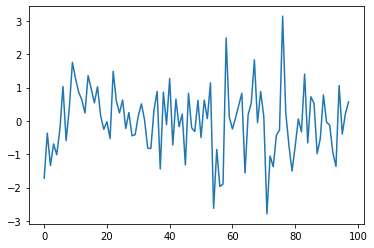

Is this oscillatory?: 0


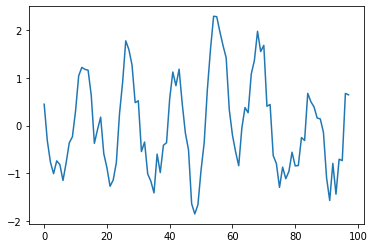

Is this oscillatory?: 1


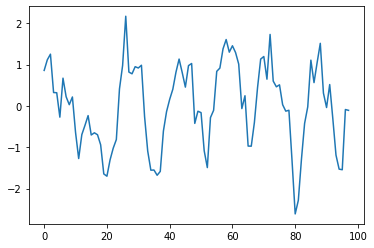

Is this oscillatory?: 1


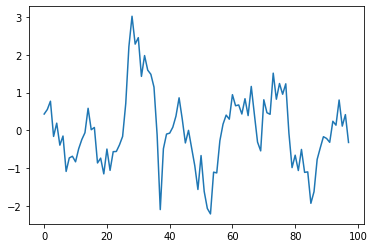

Is this oscillatory?: 2


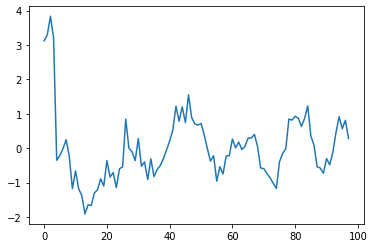

Is this oscillatory?: 1


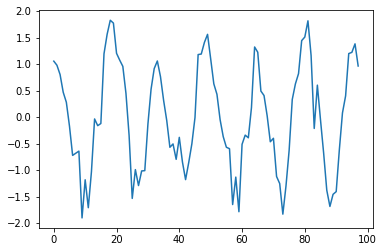

Is this oscillatory?: 1


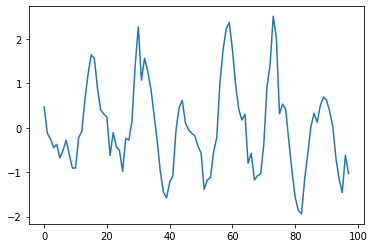

Is this oscillatory?: 1


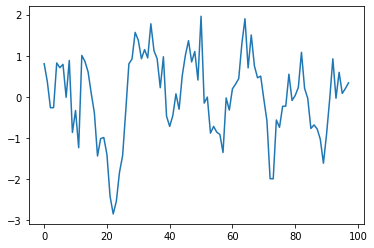

Is this oscillatory?: 1


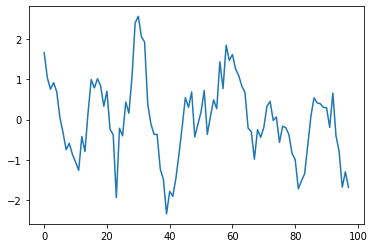

Is this oscillatory?: 2


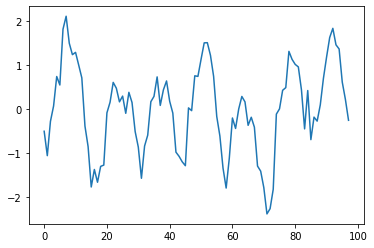

Is this oscillatory?: 1


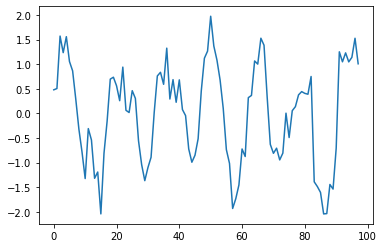

Is this oscillatory?: 1


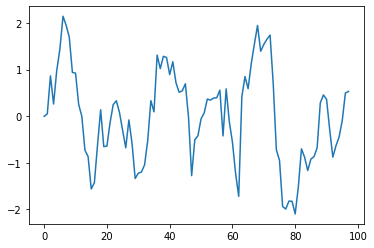

Is this oscillatory?: 2


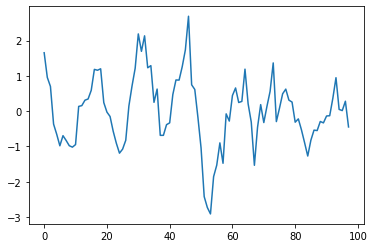

Is this oscillatory?: 1


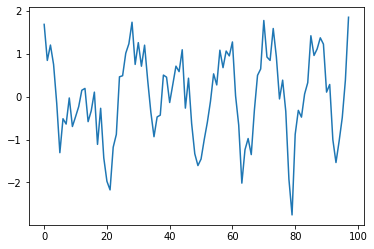

Is this oscillatory?: 1


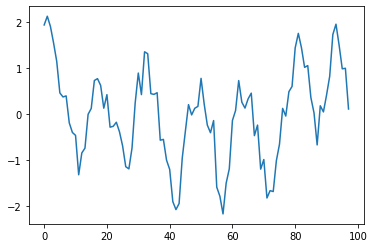

Is this oscillatory?: 1


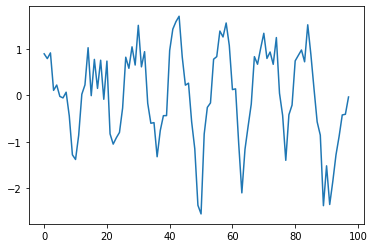

Is this oscillatory?: 1


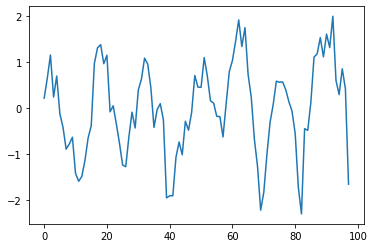

Is this oscillatory?: 1


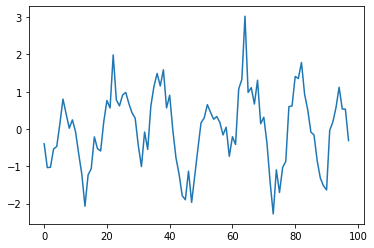

Is this oscillatory?: 1


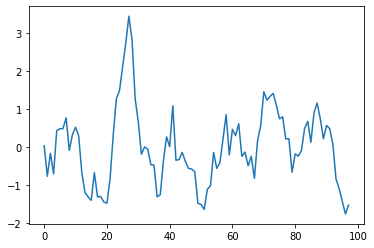

Is this oscillatory?: 2


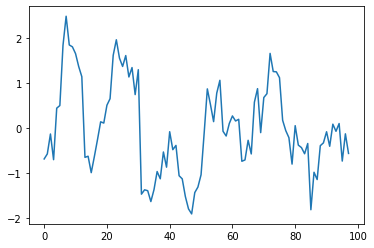

Is this oscillatory?: 2


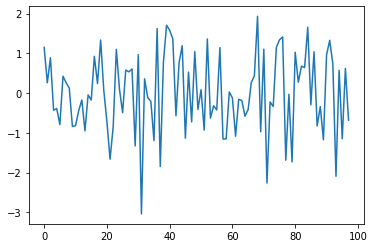

Is this oscillatory?: 0


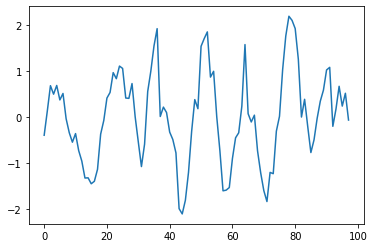

Is this oscillatory?: 1


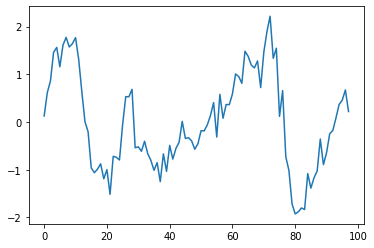

Is this oscillatory?: 0


In [45]:
for cell in Wlist:
    #cell.plot_ts(y_attr='flavin.reading_processed')
    #plt.scatter(x=list(range(len(cell.flavin.reading_processed))), y=cell.flavin.reading_processed)
    plt.plot(cell.flavin.reading_processed)
    plt.show(block=False)
    cell.flavin.category = input('Is this oscillatory?: ')

**Save scores**

Note: My old way doesn't work as it relies on no cells being deleted from a dataset. Here I'm matching cells by their MATLABid, which never changes

In [46]:
categories_list = np.array([[int(cell.MATLABid), int(cell.flavin.category)] for cell in Wlist])
np.savetxt('categories_svm_window_ternary.csv', categories_list, delimiter=',')

**Randomise scores and save them**

In [481]:
category_labels = [0,1,2]
weights = [51/294, 135/294, 108/294]
#category_labels = [0,1]
#weights = [83/294, 211/294]
categories_list = np.array([[int(cell.MATLABid), np.random.choice(category_labels, 1, p=weights)] for cell in Wlist])
np.savetxt('categories_random_ternary.csv', categories_list, delimiter=',')

/home/arin/.pyenv/versions/3.7.9/envs/time-series-pipeline/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


**Load scores**

In [8]:
categories_list_loaded = np.loadtxt('categories_svm_window_ternary.csv', delimiter=',')
for categories_item in categories_list_loaded:
    for cell in Wlist:
        if cell.MATLABid == categories_item[0]:
            cell.flavin.category = categories_item[1]

Tally by class

In [9]:
import pandas as pd

class_labels_wlist = [cell.flavin.category for cell in Wlist]
freq_table = pd.Series(class_labels_wlist).value_counts()
print(freq_table)

1.0    135
2.0    108
0.0     51
dtype: int64


(test) remove the class 2 ones

In [10]:
Wlist_backup = Wlist
Wlist = [cell for cell in Wlist if cell.flavin.category in [0,1]]
len(Wlist)

186

# Featurisation

Option 1: Use time points

In [414]:
for cell in Wlist:
    cell.flavin.feature_vector = cell.flavin.reading_processed

Option 2: Use `catch22`

In [18]:
import catch22

for cell in Testinglist_expanded:
    cell.flavin.feature_vector = catch22.catch22_all(cell.flavin.reading_processed)['values']

Option 3: FFT spectrum

In [484]:
def add_classicalAttr(cell, oversampling_factor = 1):
    """Computes classical periodogram and adds PdgramAttr attributes"""
    cell.flavin.classical.freqs, cell.flavin.classical.power = \
            pipeline.periodogram.classical(
                np.linspace(0, 5*(len(cell.flavin.reading_processed)-1), len(cell.flavin.reading_processed)),
                cell.flavin.reading_processed,
                oversampling_factor = oversampling_factor)

for cell in Wlist:
    add_classicalAttr(cell)
    cell.flavin.feature_vector = cell.flavin.classical.power

Dummy option: shitty features

In [350]:
for cell in Wlist:
    cell.flavin.feature_vector = [random.random(), random.random(), random.random(), random.random()]

Dummy option: features that should be uninformative after normalisation

In [330]:
for cell in Wlist:
    cell.flavin.feature_vector = [np.mean(cell.flavin.reading_processed),
                                 np.std(cell.flavin.reading_processed)]

Scale feature vectors for visualisation (they're scaled in the SVM routine anyway)

In [22]:
from sklearn.preprocessing import StandardScaler

data_array = np.array([cell.flavin.feature_vector for cell in Wlist])
scaler = StandardScaler()
scaler.fit(data_array)
data_array_transformed = scaler.transform(data_array)
for index, timeseries in enumerate(data_array_transformed):
    Wlist[index].flavin.feature_vector_normalised = data_array_transformed[index]

# Define training and testing data

Define cells for training data; the rest goes into testing data

In [12]:
import math
import random

training_size = 100
#training_size = math.floor(0.7*len(Wlist))

Traininglist = random.sample(Wlist, k = training_size)
Testinglist = [cell for cell in Wlist if cell not in Traininglist]

training_data = np.array([cell.flavin.feature_vector for cell in Traininglist])
class_labels = np.array([cell.flavin.category for cell in Traininglist])
testing_data = np.array([cell.flavin.feature_vector for cell in Testinglist])

print('Training data frequency table')
print(pd.Series(class_labels).value_counts())

Training data frequency table
1.0    77
0.0    23
dtype: int64


Visualise training data time series

In [13]:
import seaborn as sns

training_timeseries_array = np.array([cell.flavin.reading_processed for cell in Traininglist])

for class_label in set(class_labels):
    fig, ax = plt.subplots()
    sns.heatmap(
        [cell.flavin.reading_processed
             for cell in Traininglist
             if cell.flavin.category == class_label],
        vmin = np.min(training_timeseries_array),
        vmax = np.max(training_timeseries_array),
        center = 0, cmap = 'vlag',)
    plt.title(class_label)
    plt.show()
    
fig, ax = plt.subplots()
for class_label in set(class_labels):
    plt.plot(
        np.mean(
            [cell.flavin.reading_processed
                for cell in Traininglist
                if cell.flavin.category == class_label],
            axis = 0
        ),
        label=class_label,)
plt.legend()
plt.show()

Visualise training data feature vectors

In [14]:
import seaborn as sns

for class_label in set(class_labels):
    fig, ax = plt.subplots()
    sns.heatmap(
        [feature_vector
             for index, feature_vector in enumerate(training_data)
             if class_labels[index] == class_label],
        vmin = np.min(training_data),
        vmax = np.max(training_data),
        center = 0, cmap = 'vlag',)
    plt.title('Class ' + str(int(class_label)))
    plt.xlabel('Feature')
    plt.ylabel('Cell')
    plt.show()
    
fig, ax = plt.subplots()
for class_label in set(class_labels):
    plt.plot(
        np.mean(
            [feature_vector
                for index, feature_vector in enumerate(training_data)
                if class_labels[index] == class_label],
            axis = 0
        ),
        label=class_label,)
plt.title('Mean')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.legend()
plt.show()

# Train a model

*To do: really use `make_pipeline` to make my life easier, implement blocks to tune hyperparameters when I'm sure that there's no overfitting*

Train SVM classifier

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(training_data, class_labels)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

Inspect (hyper)parameters

In [16]:
clf.get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('svc',
   SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
       decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
       max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
       verbose=False))],
 'verbose': False,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'svc': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'sv

(Additional cell for ternary)

In [19]:
Wlist_backup_MATLABids = [cell.MATLABid for cell in Wlist_backup]
Traininglist_MATLABids = [cell.MATLABid for cell in Traininglist]

Testinglist_expanded = [cell for cell in Wlist_backup if cell.MATLABid not in Traininglist_MATLABids]

testing_data_expanded = np.array([cell.flavin.feature_vector for cell in Testinglist_expanded])

len(set(Testinglist_expanded))

194

Use trained model to predict categories, list cells predicted to be in each category, store predicted categories in cell objects

In [20]:
predictions = clf.predict(testing_data_expanded)

predictions_dict = {}
for class_label in set(class_labels):
    predictions_dict[class_label] = [index
                                        for index, predicted_label in enumerate(predictions)
                                        if predicted_label == class_label]
    
print(predictions_dict)

for index, predicted_category in enumerate(predictions):
    Testinglist_expanded[index].flavin.predicted_category = predicted_category

{0.0: [0, 5, 29, 35, 38, 40, 48, 51, 82, 92, 97, 103, 105, 111, 117, 122, 123, 127, 129, 130, 138, 139, 141, 144, 149, 152, 153, 158, 159, 160, 161, 162, 163, 164, 167, 171, 172, 178, 180, 182, 183, 193], 1.0: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 98, 99, 100, 101, 102, 104, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 118, 119, 120, 121, 124, 125, 126, 128, 131, 132, 133, 134, 135, 136, 137, 140, 142, 143, 145, 146, 147, 148, 150, 151, 154, 155, 156, 157, 165, 166, 168, 169, 170, 173, 174, 175, 176, 177, 179, 181, 184, 185, 186, 187, 188, 189, 190, 191, 192]}


Inspect one of these by plotting

In [21]:
plt.plot(Testinglist[34].flavin.reading_processed)

If `predict_proba` is true, get probabilities

In [22]:
probabilities = clf.predict_proba(testing_data)
indices = np.atleast_2d(range(len(testing_data)))
pd.set_option('display.max_rows', None)
df = pd.DataFrame(probabilities)
df

0         1
0   0.923625  0.076375
1   0.038347  0.961653
2   0.011079  0.988921
3   0.975201  0.024799
4   0.048873  0.951127
5   0.009057  0.990943
6   0.270326  0.729674
7   0.167838  0.832162
8   0.011282  0.988718
9   0.025802  0.974198
10  0.010956  0.989044
11  0.012844  0.987156
12  0.011382  0.988618
13  0.019642  0.980358
14  0.060188  0.939812
15  0.028066  0.971934
16  0.608846  0.391154
17  0.745145  0.254855
18  0.054566  0.945434
19  0.005997  0.994003
20  0.031002  0.968998
21  0.008586  0.991414
22  0.012908  0.987092
23  0.087481  0.912519
24  0.983400  0.016600
25  0.067332  0.932668
26  0.017673  0.982327
27  0.008466  0.991534
28  0.022579  0.977421
29  0.008510  0.991490
30  0.033628  0.966372
31  0.395682  0.604318
32  0.022521  0.977479
33  0.019121  0.980879
34  0.013736  0.986264
35  0.044383  0.955617
36  0.005482  0.994518
37  0.058242  0.941758
38  0.037791  0.962209
39  0.915766  0.084234
40  0.003152  0.996848
41  0.134665  0.865335
42  0.984030  0.015970
43  0.888669  0.111331
44  0.014533  0.985467
45  0.014047  0.985953
46  0.957378  0.042622
47  0.790109  0.209891
48  0.018703  0.981297
49  0.054818  0.945182
50  0.954071  0.045929
51  0.956785  0.043215
52  0.986795  0.013205
53  0.005517  0.994483
54  0.042682  0.957318
55  0.961906  0.038094
56  0.982935  0.017065
57  0.010836  0.989164
58  0.920704  0.079296
59  0.003739  0.996261
60  0.129554  0.870446
61  0.009301  0.990699
62  0.984028  0.015972
63  0.970352  0.029648
64  0.959461  0.040539
65  0.891965  0.108035
66  0.975641  0.024359
67  0.009053  0.990947
68  0.020473  0.979527
69  0.932757  0.067243
70  0.027130  0.972870
71  0.967617  0.032383
72  0.971880  0.028120
73  0.007810  0.992190
74  0.014814  0.985186
75  0.029617  0.970383
76  0.014241  0.985759
77  0.958449  0.041551
78  0.913023  0.086977
79  0.016056  0.983944
80  0.985268  0.014732
81  0.145327  0.854673
82  0.014719  0.985281
83  0.090591  0.909409
84  0.009897  0.990103
85  0.975062  0.024938

Arrange cells by probabilities

In [23]:
df_sort = df.sort_values(by=[1])
df_sort

0         1
52  0.986795  0.013205
80  0.985268  0.014732
42  0.984030  0.015970
62  0.984028  0.015972
24  0.983400  0.016600
56  0.982935  0.017065
66  0.975641  0.024359
3   0.975201  0.024799
85  0.975062  0.024938
72  0.971880  0.028120
63  0.970352  0.029648
71  0.967617  0.032383
55  0.961906  0.038094
64  0.959461  0.040539
77  0.958449  0.041551
46  0.957378  0.042622
51  0.956785  0.043215
50  0.954071  0.045929
69  0.932757  0.067243
0   0.923625  0.076375
58  0.920704  0.079296
39  0.915766  0.084234
78  0.913023  0.086977
65  0.891965  0.108035
43  0.888669  0.111331
47  0.790109  0.209891
17  0.745145  0.254855
16  0.608846  0.391154
31  0.395682  0.604318
6   0.270326  0.729674
7   0.167838  0.832162
81  0.145327  0.854673
41  0.134665  0.865335
60  0.129554  0.870446
83  0.090591  0.909409
23  0.087481  0.912519
25  0.067332  0.932668
14  0.060188  0.939812
37  0.058242  0.941758
49  0.054818  0.945182
18  0.054566  0.945434
4   0.048873  0.951127
35  0.044383  0.955617
54  0.042682  0.957318
1   0.038347  0.961653
38  0.037791  0.962209
30  0.033628  0.966372
20  0.031002  0.968998
75  0.029617  0.970383
15  0.028066  0.971934
70  0.027130  0.972870
9   0.025802  0.974198
28  0.022579  0.977421
32  0.022521  0.977479
68  0.020473  0.979527
13  0.019642  0.980358
33  0.019121  0.980879
48  0.018703  0.981297
26  0.017673  0.982327
79  0.016056  0.983944
74  0.014814  0.985186
82  0.014719  0.985281
44  0.014533  0.985467
76  0.014241  0.985759
45  0.014047  0.985953
34  0.013736  0.986264
22  0.012908  0.987092
11  0.012844  0.987156
12  0.011382  0.988618
8   0.011282  0.988718
2   0.011079  0.988921
10  0.010956  0.989044
57  0.010836  0.989164
84  0.009897  0.990103
61  0.009301  0.990699
5   0.009057  0.990943
67  0.009053  0.990947
21  0.008586  0.991414
29  0.008510  0.991490
27  0.008466  0.991534
73  0.007810  0.992190
19  0.005997  0.994003
53  0.005517  0.994483
36  0.005482  0.994518
59  0.003739  0.996261
40  0.003152  0.996848

Plot histogram of probabilities of oscillation

In [35]:
plt.hist(probabilities[:,1], 40)

(array([12.,  6.,  5.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  3.,  0.,  2.,  5.,  9.,
        36.]),
 array([0.01320516, 0.03779622, 0.06238728, 0.08697834, 0.1115694 ,
        0.13616046, 0.16075152, 0.18534258, 0.20993363, 0.23452469,
        0.25911575, 0.28370681, 0.30829787, 0.33288893, 0.35747999,
        0.38207105, 0.40666211, 0.43125317, 0.45584422, 0.48043528,
        0.50502634, 0.5296174 , 0.55420846, 0.57879952, 0.60339058,
        0.62798164, 0.6525727 , 0.67716376, 0.70175481, 0.72634587,
        0.75093693, 0.77552799, 0.80011905, 0.82471011, 0.84930117,
        0.87389223, 0.89848329, 0.92307434, 0.9476654 , 0.97225646,
        0.99684752]),
 <BarContainer object of 40 artists>)

Visualise testing data time series

In [469]:
import seaborn as sns

testing_timeseries_array = np.array([cell.flavin.reading_processed for cell in Testinglist])

for class_label in set(class_labels):
    fig, ax = plt.subplots()
    sns.heatmap(
        [cell.flavin.reading_processed
             for cell in Testinglist
             if cell.flavin.predicted_category == class_label],
        vmin = np.min(testing_timeseries_array),
        vmax = np.max(testing_timeseries_array),
        center = 0, cmap = 'vlag',)
    plt.title(class_label)
    plt.show()
    
fig, ax = plt.subplots()
for class_label in set(class_labels):
    plt.plot(
        np.mean(
            [cell.flavin.reading_processed
                for cell in Testinglist
                if cell.flavin.predicted_category == class_label],
            axis = 0
        ),
        label=class_label,)
plt.legend()
plt.show()

Visualise testing data feature vectors

In [479]:
import seaborn as sns

import seaborn as sns

testing_featurevector_array = np.array([cell.flavin.feature_vector for cell in Testinglist])

for class_label in set(class_labels):
    fig, ax = plt.subplots()
    sns.heatmap(
        [cell.flavin.feature_vector
             for cell in Testinglist
             if cell.flavin.predicted_category == class_label],
        vmin = np.min(testing_featurevector_array),
        vmax = np.max(testing_featurevector_array),
        center = 0, cmap = 'vlag',)
    plt.title('Class ' + str(int(class_label)))
    plt.xlabel('Feature')
    plt.ylabel('Cell')
    plt.show()
    
fig, ax = plt.subplots()
for class_label in set(class_labels):
    plt.plot(
        np.mean(
            [cell.flavin.feature_vector
                for cell in Testinglist
                if cell.flavin.predicted_category == class_label],
            axis = 0
        ),
        label=class_label,)
plt.title('Mean')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.legend()
plt.show()

# Verification

Confusion matrix, precision, recall

In [471]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

categories_true = [cell.flavin.category for cell in Testinglist]
categories_predicted = [cell.flavin.predicted_category for cell in Testinglist]

print('Categories')
print(list(set(categories_true)))
print('Confusion matrix (axes conform to above)')
cm = confusion_matrix(categories_true, categories_predicted, labels = list(set(categories_true)))
print(cm)

print('Precision')
print(precision_score(categories_true, categories_predicted, average='weighted'))
print('Recall')
print(recall_score(categories_true, categories_predicted, average='weighted'))

Categories
[0.0, 1.0, 2.0]
Confusion matrix (axes conform to above)
[[23  0  8]
 [ 3 72 17]
 [ 2 29 40]]
Precision
0.694539957847603
Recall
0.6958762886597938


k-fold cross-validation (statified, to deal with class imbalance)

In [491]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import precision_score, recall_score

kfold_data = np.array([cell.flavin.feature_vector for cell in Wlist])
kfold_classlabels = np.array([cell.flavin.category for cell in Wlist])

kf = StratifiedKFold(n_splits = 5)
print(kf)

# make_pipeline probably makes all this easier...
for train_index, test_index in kf.split(kfold_data, kfold_classlabels):
    # Split training-testing
    kfold_data_train, kfold_data_test = kfold_data[train_index], kfold_data[test_index]
    kfold_classlabels_train, kfold_classlabels_test = kfold_classlabels[train_index], kfold_classlabels[test_index]
    
    # Train model
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(kfold_data_train, kfold_classlabels_train)
    
    # Predict
    categories_predicted = clf.predict(kfold_data_test)
    
    # Compute measures
    print(
        'Precision ' +
        '%.4f' % precision_score(kfold_classlabels_test, categories_predicted, average='weighted') +
        ' Recall ' +
        '%.4f' % recall_score(kfold_classlabels_test, categories_predicted, average='weighted') +
        '\n')


StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
Precision 0.7815 Recall 0.7627

Precision 0.7867 Recall 0.7797

Precision 0.6601 Recall 0.6441

Precision 0.8468 Recall 0.8305

Precision 0.7420 Recall 0.7414



ROC curve **(WORK IN PROGRESS)**

In [54]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

training_data = np.array([cell.flavin.feature_vector for cell in Traininglist])
training_classlabels = np.array([cell.flavin.category for cell in Traininglist])
testing_data = np.array([cell.flavin.feature_vector for cell in Testinglist])
testing_classlabels = np.array([cell.flavin.category for cell in Testinglist])

clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(training_data, training_classlabels)
probabilities = clf.predict_proba(testing_data)
scores = probabilities[:,1]
    
false_positive_rate, true_positive_rate, _ = roc_curve(testing_classlabels, scores)

plt.plot(false_positive_rate, true_positive_rate)